In [76]:
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import xgboost as xgb
import copy as cp
import geoplot as gplt
import geopandas as gpd
%matplotlib inline
sns.set_style("white")

from geoplot import crs as gcrs
from shapely.geometry import Point
from itertools import chain, product
from collections import Counter, OrderedDict
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from tap import modelmetrics, modelparams
from matplotlib.ticker import FuncFormatter

In [127]:
# Constants
params = modelparams.get_constants()
dirs = modelparams.get_data_dir()
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
met = modelmetrics.metrics()
accident_severity_mapping = {
    1: "Fatal",
    2: "Severe",
    3: "Slight"
}
day_of_week_mapping = {
    1: "Sun",
    2: "Mon",
    3: "Tue",
    4: "Wed",
    5: "Thu",
    6: "Fri",
    7: "Sat"    
}
month_mapping = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec"
}
one_hot_feature_mapping = joblib.load("./feature_mapping.oh.pkl.xz")
droppable_columns = np.array(["Longitude", "Latitude", "Date_Time", "Year", "Accident_Index", 
                              "Accident_Severity", "Casualty_Severity"])
ordinal = np.array(["Accident_Severity", "Speed_Limit", "Age_Band_of_Casualty", "Number_of_Vehicles", 
                    "Number_of_Casualties", 'Age_Band_of_Driver'])

In [102]:
# Classes and functions
# Plot a global mean horizontal line on a line plot for labels freater than min_label
# Otherwise, plot a histogram of counts per label on select_col
def plot_mean_relation_with(data, fig, select_col, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, min_label = 5):
    if not isinstance(select_col, str):
        print('Only 1 feature can be selected')
        return
    if select_col not in data.columns:
        print('Selected column must contain in the dataframe')
        return
    data_cols = data.columns.drop(select_col) if exclusion_list is None else data.columns.drop(exclusion_list + [select_col])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    global_mean = data[select_col].mean()
    
    countplot_cols = list()
    for col in data_cols:
        if len(pd.unique(data[col])) > min_label:
            ax = fig.add_subplot(nrow, ncol, ind)
            ax.plot(data.loc[:, (col, select_col)].groupby(col).mean())
            ax.axhline(global_mean, color = 'r', linestyle = '--')
        else:
            countplot_cols.append(col)
            continue
        ax.set_title(col.replace('_', ' '))
        if len(data_cols) - len(countplot_cols) - ind <= ncol + len(countplot_cols):
            ax.set_xlabel('Label')
        if ind % ncol == 1:
            ax.set_ylabel(select_col + ' (Mean)')
        ind += 1

    if (ind - 1) % ncol != 0:
        ind += (ind % ncol) + 1
    
    for col in countplot_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        sns.countplot(data = data, ax = ax, x = col, hue = select_col)
        ind += 1
        
def plot_lv_relation_with(data, fig, dv, hue = None, nrow = -1, ncol = 3, ind = 1, exclusion_list = None, 
                         orient = 'v'):
    if not isinstance(dv, str):
        print('Independant variable must be single feature')
        return
    data_cols = data.columns.drop(dv) if exclusion_list is None else data.columns.drop(exclusion_list + [dv])
    if nrow < 0:
        nrow = np.ceil(len(data_cols) / ncol) + 2
    
    for col in data_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        if hue is not None:
            sns.lvplot(data = data, x = col, y = dv, hue = hue, ax = ax, orient = orient)
        else:
            sns.lvplot(data = data, x = col, y = dv, ax = ax, orient = orient)
        if ind % ncol != 1:
            ax.set_ylabel('')
        ind += 1
    sns.despine()
    
    return ind
    
def drop_records_after(before, after):
    return after.drop(after.index[after.set_index('Accident_Index').index.isin(before.set_index('Accident_Index').index) ^ True], 
         axis=0)

# Create calender of GB Bank Holidays
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=sunday_to_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=sunday_to_monday),
        Holiday('Boxing Day', month=12, day=26, observance=next_monday_or_tuesday)
    ]
    
def dt_general_plotter(ax, data, by, label, scaler = MinMaxScaler()):
    return ax.plot(*zip(*[
        (yr, cnt[0])
        for yr, cnt in zip(range(min(by), max(by) + 1), 
                           scaler.fit_transform(np.array(data.groupby(by).count()).reshape(-1, 1)))
    ]), label=label)
    
def plot_yearly_missing_data_cols(data, fig, nrow = -1, ncol = 3, ind = 1):
    missing_cols = sorted([(x, col) for col, x in zip(data.columns, data.isnull().sum(axis=0).tolist()) if x > 0])
    if nrow < 0:
        nrow = np.ceil(len(missing_cols) / 3)

    for (x, col) in missing_cols:
        ax = fig.add_subplot(nrow, ncol, ind)
        missing_group = data.loc[:, ('Year', col)].groupby('Year').apply(lambda x: x.loc[x[col].isnull(), 'Year'].count())
        percent_missing = np.round((x/len(data)) * 100, 2)
        ax.bar(*zip(*[(ind, val) for ind, val in zip(missing_group.index, missing_group)]), 
               label='Total: ' + str(x) + " (" + (str(percent_missing) if percent_missing >= 0.01 else "0.01") + "%)")
        ax.set_title(col.replace('_', ' '))
        if len(missing_cols) - ind < ncol:
            ax.set_xlabel('Year')
            ax.set_xticks(sorted(data["Year"].unique()))
        else:
            ax.set_xticks([])
        if ind % ncol == 1:
            ax.set_ylabel('Frequency')
        ind += 1
        ax.legend()
        
# Plot Pearson correlation coefficient
def plot_pearsonr(data):
    corr = data.copy().corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def auto_drop(data):
    mask = np.isin(droppable_columns, data.columns)
    return data.drop(droppable_columns[mask], axis=1) if any(mask) else data
    
def plot_stacked_bar_severity(data, by, ax):
    tmp = data.groupby([by, "Accident_Severity"]).count()["Accident_Index"]
    
    slight = list(tmp[list(range(2, len(tmp), 3))])
    severe = list(tmp[list(range(1, len(tmp), 3))])
    fatal = list(tmp[list(range(0, len(tmp), 3))])
    chrono = sorted(data[by].unique())
    
    p1 = ax.bar(chrono, slight, label="Slight")
    p2 = ax.bar(chrono, severe, bottom=slight, label="Severe")
    p3 = ax.bar(chrono, fatal, bottom=np.add(slight, severe), color='#d62728', label="Fatal")

    ax.set_ylabel('Number of Accidents')
    ax.set_xlabel(by)
    ax.set_xticks(chrono)
    if by == "Day_of_Week":
        ax.set_xticklabels([day_of_week_mapping[d] for d in chrono])
    elif by == "Month":
        ax.set_xticklabels([month_mapping[m] for m in chrono])
    
    return [p1, p2, p3]

def count_all(data, catls, hue, fig, nrow = -1, ncol = 3, ind = 1, 
              excl_col=["Day_of_Week", "Year", "Month", "Hour", "Minute", "Accident_Severity"]):
    hascat = catls[np.isin(catls, data.columns)]
    if excl_col is not None:
        hascat = hascat[np.isin(hascat, excl_col, invert=True)]
    if nrow <= 0:
        nrow = len(hascat)
    for cat in hascat:
        if len(data[cat].unique()) > 15:
            continue # can't see anything
        ax = fig.add_subplot(nrow, ncol, ind)
        g = sns.countplot(x=cat, data=data, hue=hue, ax=ax)
        if ind % ncol != 1:
            ax.set_ylabel("")
        ax.xaxis.set_ticklabels([int(val) for val in data[cat].values if not np.isnan(val)])
        ind += 1
    return ind

def reverse_dummy(data, split_by="_"):
    avail_cols = set()
    for k, v in one_hot_feature_mapping.items():
        if any(np.isin(v, data.columns)):
            avail_cols.add(k)
    get_cols = dict()
    for k in avail_cols:
        if len(one_hot_feature_mapping[k]) == 1:
            get_cols[k] = data[k]
        else:
            get_cols[k] = data[one_hot_feature_mapping[k]].idxmax(axis=1)
    get_cols = pd.DataFrame(get_cols)
    for col in get_cols.columns:
        if not np.issubdtype(get_cols[col], int):
            tmp = get_cols[col].str.split("_", expand=True)
            get_cols[col] = tmp[len(tmp.columns) - 1].astype("int64").copy()
    return get_cols.copy()

def simple_line_numeric(x, y):
    return zip(*sorted(zip(x, y)))

# Reference: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.BuGn):
    norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(norm_cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], "d") + "\n(" + format(norm_cm[i, j], ".2f") + ")",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def to_geodf(data, lon="Longitude", lat="Latitude", dropna=True):
    data = data.copy().dropna(subset=[lon, lat])
    return gpd.GeoDataFrame(data,
                     geometry=data.apply(lambda srs: Point(srs[lon], srs[lat]), axis='columns'))


In [4]:
# Import original data
acc = pd.read_csv(dirs["orig"] + 'acc2005_2016.csv')
cas = pd.read_csv(dirs["orig"] + 'cas2005_2016.csv')
veh = pd.read_csv(dirs["orig"] + 'veh2005_2016.csv')

# Replace all -1 missing values to NA
acc.replace(-1, np.nan, inplace=True)
veh.replace(-1, np.nan, inplace=True)
cas.replace(-1, np.nan, inplace=True)

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocessing

In [5]:
# Tidy up columns names
acc.rename(lambda x: x.replace('.', ''), axis=1, inplace=True) # Inplace to ensure it changes the variable itself
acc.rename(columns={
    'Speed_limit': 'Speed_Limit',
    'Pedestrian_CrossingHuman_Control': 'Pedestrian_Crossing_Human_Control',
    'Pedestrian_CrossingPhysical_Facilities': 'Pedestrian_Crossing_Physical_Facilities'
}, inplace=True)

veh.rename(lambda x: x.replace('.', ''), axis=1, inplace=True)
veh.rename(columns={
    'Vehicle_LocationRestricted_Lane': 'Vehicle_Location_Restricted_Lane'
}, inplace=True)


In [6]:
# Date Time cannot be imputed since there is no way to "guess" the date an accident occur, remove associated records
acc.dropna(subset=['Time', 'Speed_Limit'], inplace=True)
acc['Speed_Limit'] = acc['Speed_Limit'].astype('int64')

# We know that if the accident record doesn't exist, the vehicle record cannot exist. Therefore, remove vehicle records 
# that no longer have an associating accident
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(acc.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

# Was_Vehicle_Left_Hand_Drive feature cannot be imputed as it is part of the aim factor of the project
veh_ind = list(set(veh.loc[veh['Was_Vehicle_Left_Hand_Drive'].isnull(), 'Accident_Index']))

# Remove every record that has the feature with missing value alongside vehicles incolved with the same Accident_Index
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(veh_ind) ^ False], axis=0, inplace=True)
veh['Was_Vehicle_Left_Hand_Drive'] = veh['Was_Vehicle_Left_Hand_Drive'].astype('int64')

# Remove every Accidents which is associated with the removed Vehicles
acc.drop(acc.index[acc.set_index('Accident_Index').index.isin(veh.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

# Remove noisy features
acc.drop([
    'Location_Easting_OSGR', 'Location_Northing_OSGR', 'LSOA_of_Accident_Location',  
    'Local_Authority_District', # Local_Authority_Highway
    'Police_Force', 'Did_Police_Officer_Attend_Scene_of_Accident', # Police involvement unrelated
    'X1st_Road_Number', 'X2nd_Road_Number',
    # 'Longitude', 'Latitude', # Not used in modelling but useful in analysis
], axis=1, inplace=True)
veh.drop([
    'Vehicle_Reference', # Reference value not useful
    'Age_of_Driver', # Age_Band_of_Driver more general
    'Journey_Purpose_of_Driver' # Missing from 2005 - 2010
], axis=1, inplace=True)
cas.drop([
    'Age_of_Casualty', # Duplicate of Age_Band_of_Casualty
    'Casualty_Reference', 'Vehicle_Reference' # Reference value not useful
], axis=1, inplace=True)

acc.replace({
    'Road_Type': {9: np.nan},
    'Weather_Conditions': {9: np.nan}
}, inplace=True)
veh.replace({
    'Sex_of_Driver': {3: np.nan}
}, inplace=True)

# Integer encode
lah_le = LabelEncoder()
acc[["Local_Authority_Highway"]] = lah_le.fit_transform(acc[["Local_Authority_Highway"]])

# Combine Date and Time to utilise datetime utility from Pandas
acc['Date_Time'] = pd.to_datetime(acc['Date'] + ' ' + acc['Time'], format='%d/%m/%Y %H:%M')
acc.drop(['Date', 'Time'], axis=1, inplace=True)

# Create a new feature is_holiday to indicate if the accident occured on a holiday
ukhols = UKBankHolidays().holidays(min(acc['Date_Time']), max(acc['Date_Time']))
acc['Is_Holiday'] = 0
acc.loc[acc['Date_Time'].dt.date.apply(lambda x: x in ukhols), ('Is_Holiday')] = 1



C:\Anaconda\envs\fyp_tap_env\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# Only Minute has no useful pattern as its an interval of 5 minutes.
# Day is already included as acc.Day_of_Week
acc['Year'], acc['Month'], acc['Hour'] = acc['Date_Time'].dt.year, acc['Date_Time'].dt.month, acc['Date_Time'].dt.hour

# Odd or questionable records caught during analysis which are removed later are placed in this cell
# Speed_Limit == 0 record, makes no sense to have any road with 0 speed limit
acc.drop(acc[acc['Speed_Limit'] == 0].index, inplace=True)
veh = drop_records_after(acc, veh)

In [8]:
acccat = np.array([
    'Accident_Severity','Day_of_Week', 'Local_Authority_Highway', 'X1st_Road_Class', 'Road_Type',
    'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class', 'Pedestrian_Crossing_Human_Control',
    'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
    'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Is_Holiday', 
    'Year', 'Month','Hour'
])
cascat = np.array([
    'Casualty_Class', 'Sex_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 
    'Car_Passenger', 'Bus_or_Coach_Passenger','Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
    'Casualty_Home_Area_Type', 'Casualty_IMD_Decile'
])
vehcat = np.array([
    'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location_Restricted_Lane',
    'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway',
    'Hit_Object_off_Carriageway', 'X1st_Point_of_Impact','Was_Vehicle_Left_Hand_Drive', 'Sex_of_Driver',
    'Engine_Capacity_CC', 'Propulsion_Code','Driver_IMD_Decile', 'Driver_Home_Area_Type', 'Vehicle_IMD_Decile'
])

# for cat in acccat:
#     acc[cat] = acc[cat].astype("category")
# for cat in cascat:
#     cas[cat] = cas[cat].astype("category")
# for cat in vehcat:
#     veh[cat] = veh[cat].astype("category")

In [9]:
###############END######################

# Analysis 1

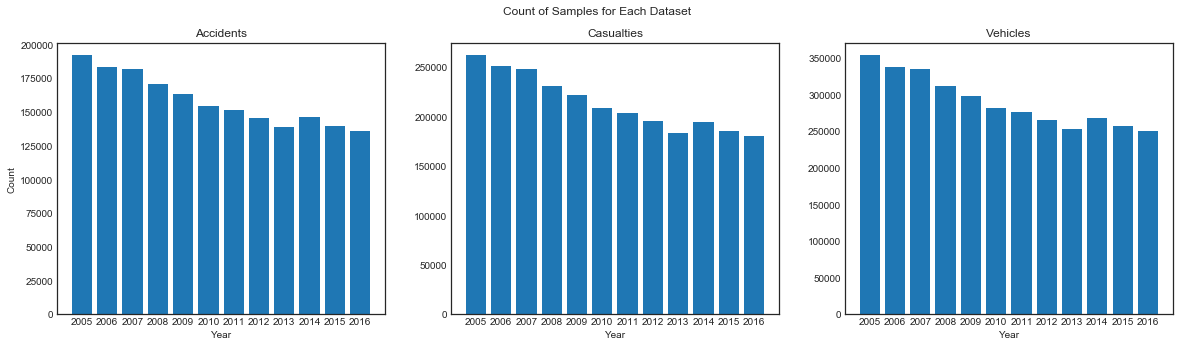

In [10]:
fig = plt.figure(figsize=[20, 5])
ind = 131

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(acc["Year"].unique(), list(acc.groupby("Year").count()["Accident_Index"]))
ax.bar(x, y)
ax.set_ylabel("Count")
ax.set_xlabel("Year")
ax.set_xticks(sorted(acc["Year"].unique()))
ax.set_title("Accidents")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(acc["Year"].unique(), 
                           list(cas.merge(acc[["Accident_Index", "Year"]], how="left").groupby("Year").count()["Accident_Index"]))
ax.bar(x, y)
ax.set_xlabel("Year")
ax.set_xticks(sorted(acc["Year"].unique()))
ax.set_title("Casualties")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(acc["Year"].unique(), 
                           list(veh.merge(acc[["Accident_Index", "Year"]], how="left").groupby("Year").count()["Accident_Index"]))
ax.bar(x, y)
ax.set_xlabel("Year")
ax.set_xticks(sorted(acc["Year"].unique()))
ax.set_title("Vehicles")
ind += 1

fig.suptitle("Count of Samples for Each Dataset")
plt.show()

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


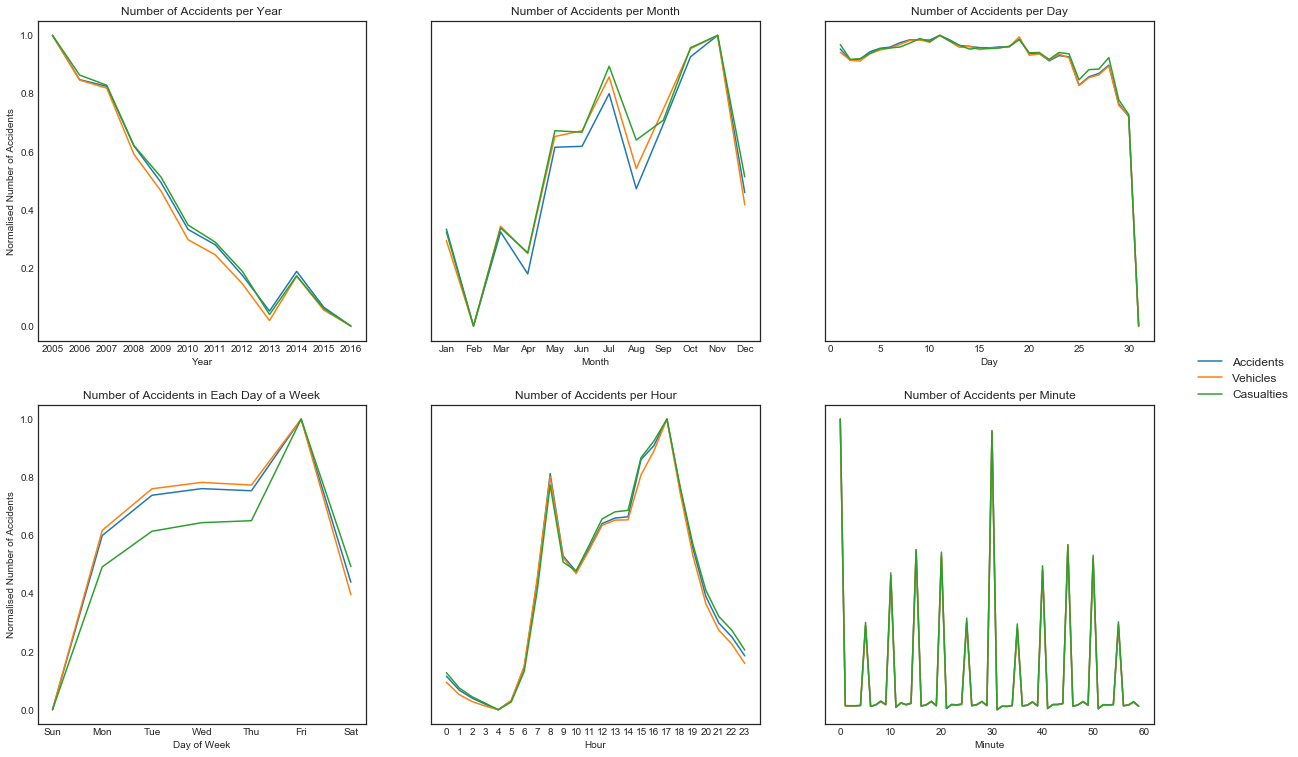

In [11]:
veh_ind = pd.DataFrame({
    'Accident_Index': veh['Accident_Index']
}).merge(acc.loc[:, ('Accident_Index', 'Date_Time', 'Day_of_Week')], on = 'Accident_Index', how = 'inner')
cas_ind = pd.DataFrame({
    'Accident_Index': cas['Accident_Index']
}).merge(acc.loc[:, ('Accident_Index', 'Date_Time', 'Day_of_Week')], on = 'Accident_Index', how = 'inner')
hold = 'Accident_Index'
dtm = 'Date_Time'

fig = plt.figure(figsize=[20,20])
# fig.set_facecolor("white")
nrow, ncol, ind = 3, 3, 1

# Year
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.year, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.year, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.year, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.year.unique())
ax.set_xlabel("Year")
ax.set_ylabel("Normalised Number of Accidents")
ax.set_title('Number of Accidents per Year')
ind += 1

# Month
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.month, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.month, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.month, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.month.unique())
ax.set_xlabel("Month")
ax.set_xticks(sorted(acc["Month"].unique()))
ax.set_xticklabels([month_mapping[m] for m in sorted(acc["Month"].unique())])
ax.set_title('Number of Accidents per Month')
ax.set_yticks([])
ind += 1

# Day
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.day, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.day, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.day, 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents per Day')
ax.set_xlabel("Day")
ax.set_yticks([])
ind += 1

ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc["Day_of_Week"], 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind["Day_of_Week"], 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind["Day_of_Week"], 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents in Each Day of a Week')
ax.set_xlabel("Day of Week")
ax.set_xticks(sorted(acc["Day_of_Week"].unique()))
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax.set_ylabel("Normalised Number of Accidents")
ind += 1

# Hour
ax = fig.add_subplot(nrow, ncol, ind)
dt_general_plotter(ax, acc[hold], acc[dtm].dt.hour, 'Accidents', min_max_scaler)
dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.hour, 'Vehicles', min_max_scaler)
dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.hour, 'Casualties', min_max_scaler)
ax.set_xticks(acc[dtm].dt.hour.unique())
ax.set_xlabel("Hour")
ax.set_yticks([])
ax.set_title('Number of Accidents per Hour')
ind += 1

# Minute
ax = fig.add_subplot(nrow, ncol, ind)
l1, = dt_general_plotter(ax, acc[hold], acc[dtm].dt.minute, 'Accidents', min_max_scaler)
l2, = dt_general_plotter(ax, veh_ind[hold], veh_ind[dtm].dt.minute, 'Vehicles', min_max_scaler)
l3, = dt_general_plotter(ax, cas_ind[hold], cas_ind[dtm].dt.minute, 'Casualties', min_max_scaler)
ax.set_title('Number of Accidents per Minute')
ax.set_xlabel("Minute")
ax.set_yticks([])
ind += 1

fig.legend([l1, l2, l3], ["Accidents", "Vehicles", "Casualties"], loc="center right", fancybox=True, fontsize="large")
plt.show()

No handles with labels found to put in legend.


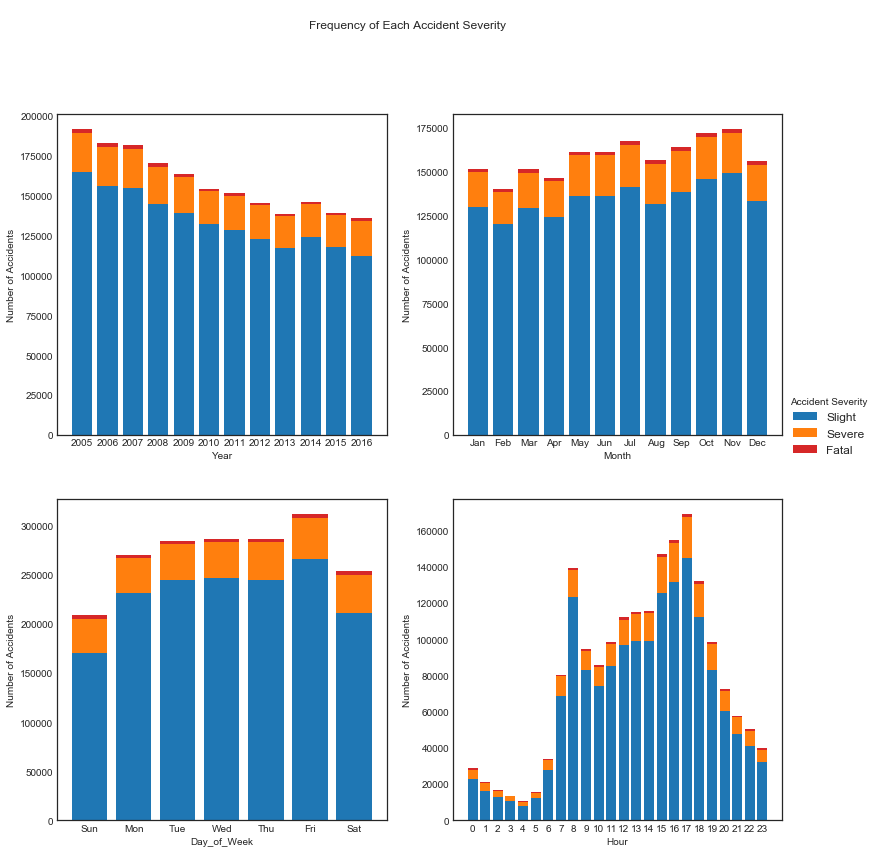

In [12]:
fig = plt.figure(figsize=[13, 13])
fig.legend()
ind = 221
leg = list()
for c in ["Year", "Month", "Day_of_Week", "Hour"]:
    ax = fig.add_subplot(ind)
    leg = plot_stacked_bar_severity(acc, c, ax)
    ind += 1

fig.suptitle("Frequency of Each Accident Severity")
fig.legend(leg, ["Slight", "Severe", "Fatal"], loc="center right", fancybox=True, fontsize="large", title="Accident Severity")
plt.show()

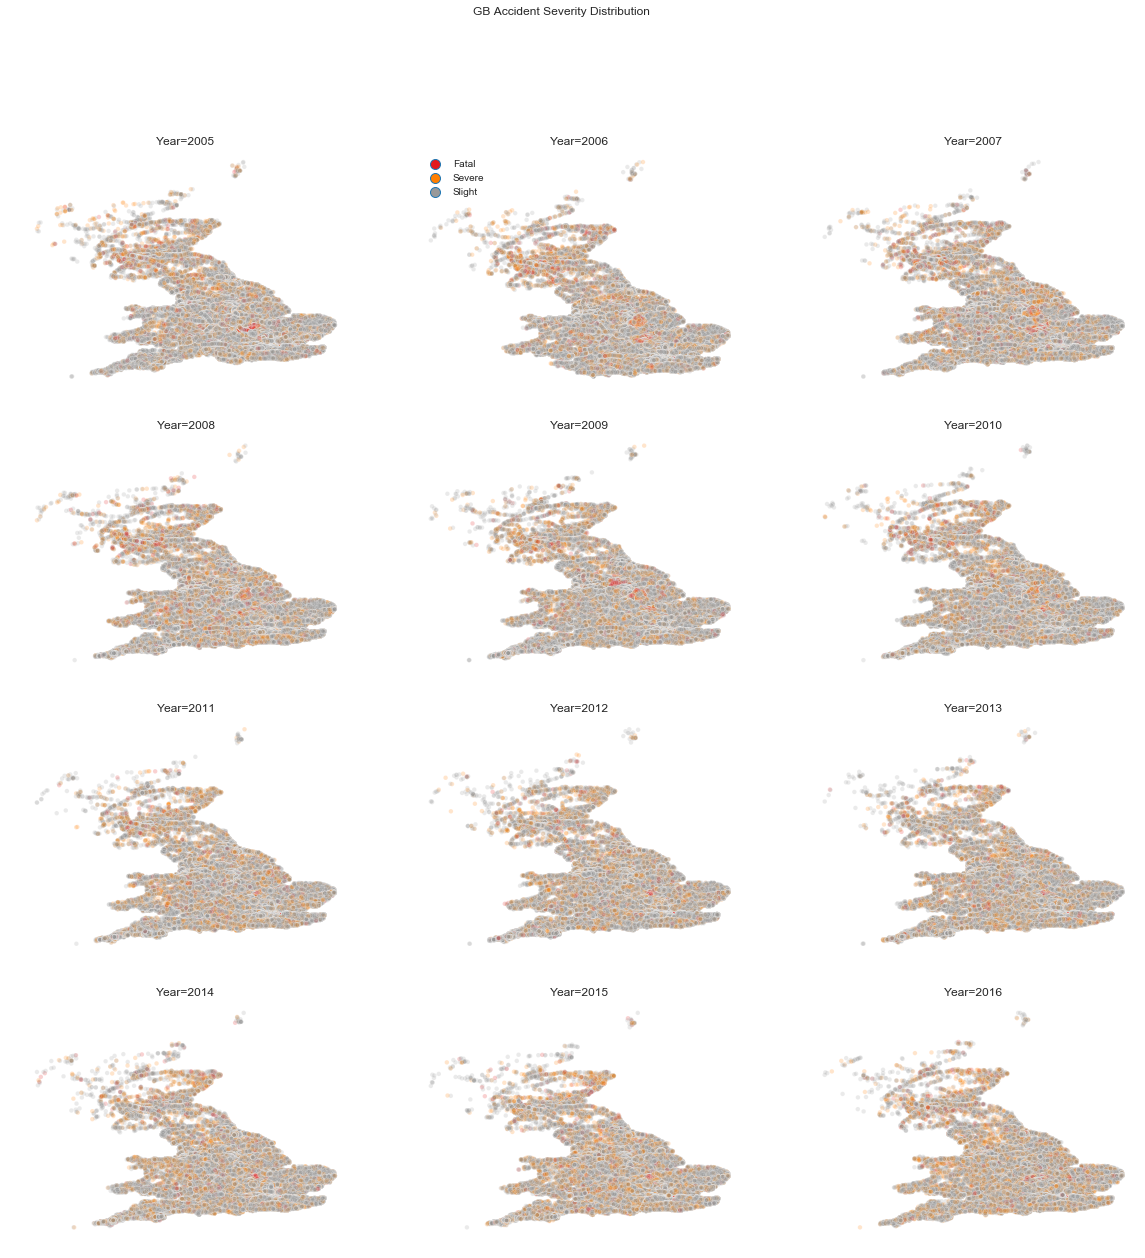

In [160]:
fig = plt.figure(figsize=[20, 20])
years = sorted(acc["Year"].unique())
ncol, ind = 3, 1
nrow = int(np.round(len(years)/ncol))

fig.suptitle("GB Accident Severity Distribution")
for yr in years:
    geodata = to_geodf(acc[acc["Year"] == yr])
    ax = fig.add_subplot(nrow, ncol, ind)
    ax.set_title("Year=" + str(yr))
    ax = gplt.pointplot(geodata, alpha=0.2, hue='Accident_Severity', categorical=True, legend_labels=["Fatal", "Severe", "Slight"],
                   legend=False if yr != 2006 else True, edgecolor='white', linewidth=0.5, legend_kwargs={'loc': 'upper left'}, ax=ax)
    ind += 1

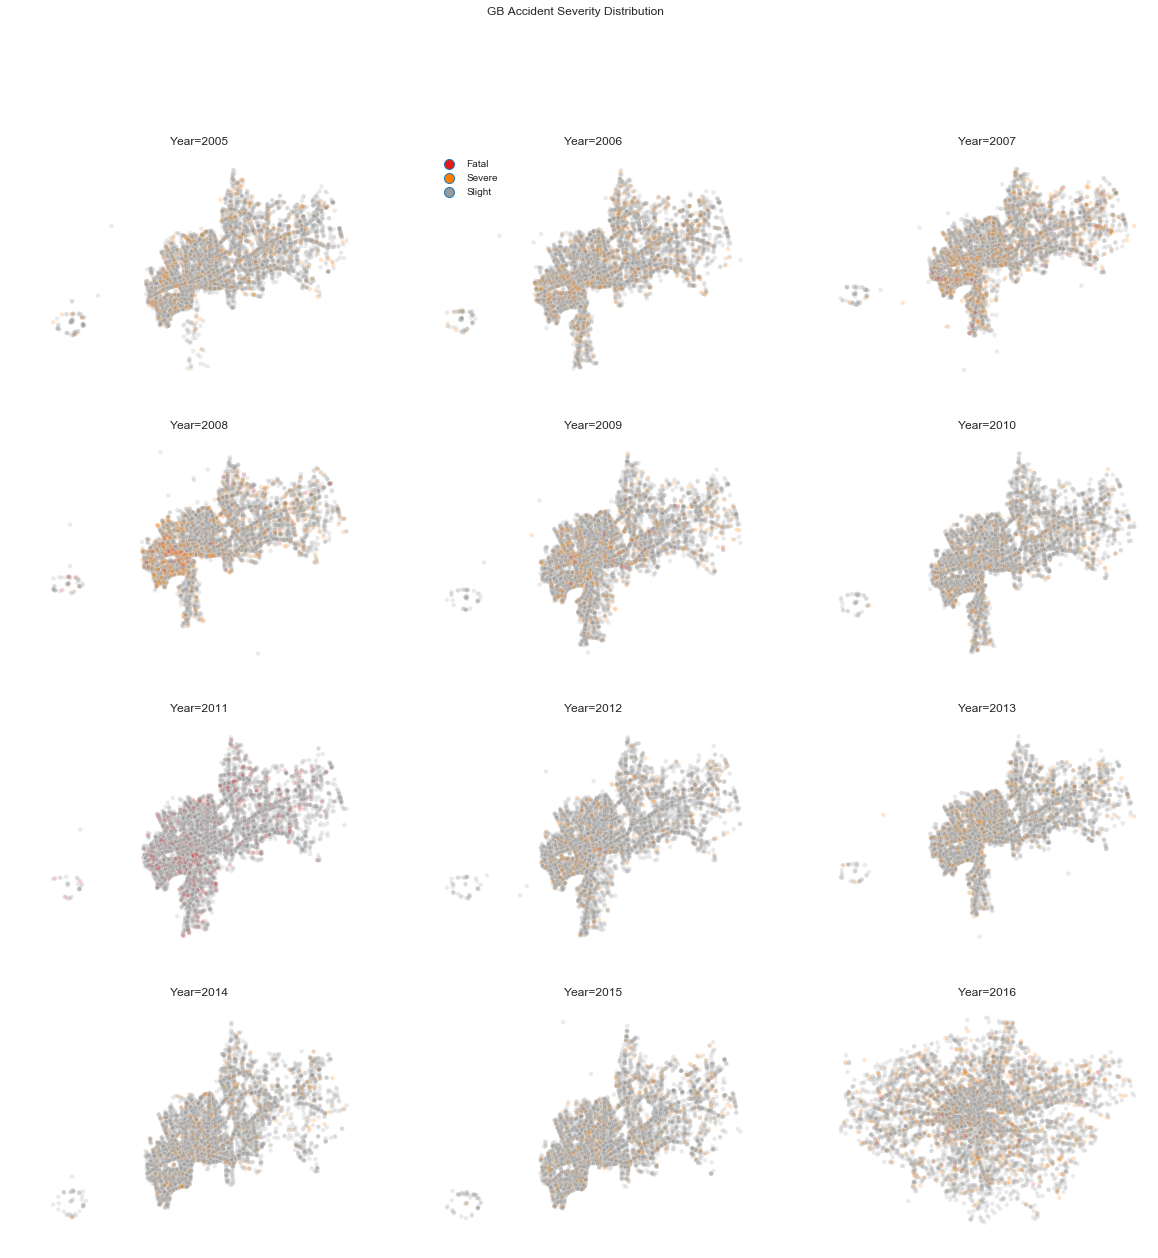

In [159]:
fig = plt.figure(figsize=[20, 20])
years = sorted(acc["Year"].unique())
ncol, ind = 3, 1
nrow = int(np.round(len(years)/ncol))

fig.suptitle("GB Accident Severity Distribution")
for yr in years:
    geodata = to_geodf(acc[acc["Year"] == yr][1:10000])
    ax = fig.add_subplot(nrow, ncol, ind)
    ax.set_title("Year=" + str(yr))
    ax = gplt.pointplot(geodata, alpha=0.2, hue='Accident_Severity', categorical=True, legend_labels=["Fatal", "Severe", "Slight"],
                   legend=False if yr != 2006 else True, edgecolor='white', linewidth=0.5, legend_kwargs={'loc': 'upper left'}, ax=ax)
    ind += 1

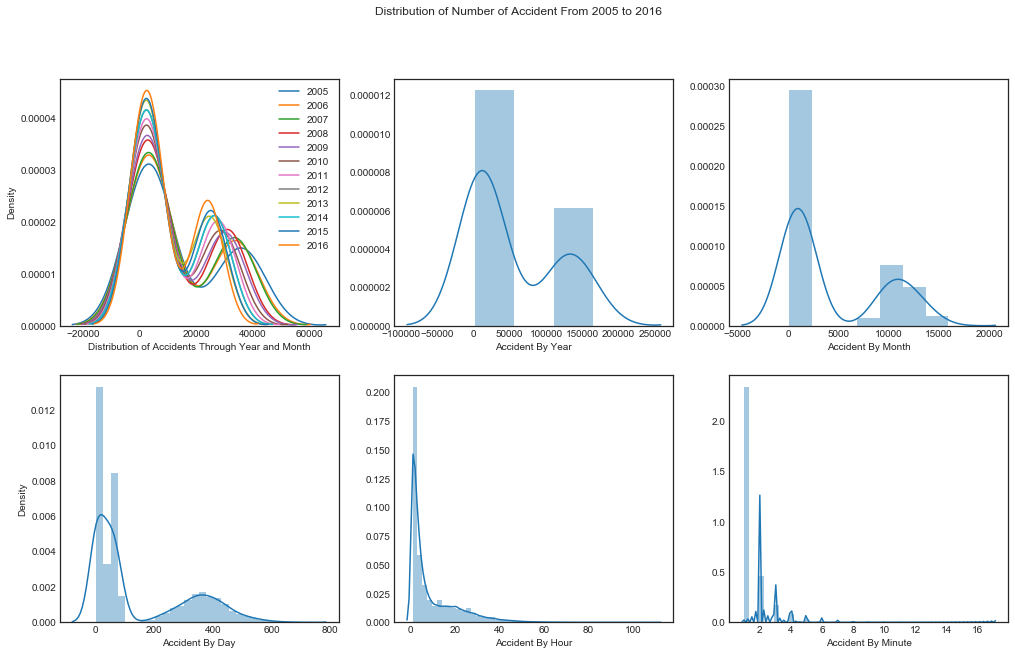

In [13]:
tmp = acc.merge(veh, on='Accident_Index').merge(cas, on='Accident_Index').groupby(
    ['Year', 'Month', 'Accident_Severity']).count()['Accident_Index']
ind = 231
fig = plt.figure(figsize=[17, 10])
fig.suptitle("Distribution of Number of Accident From 2005 to 2016")
ax = fig.add_subplot(ind)
for yr in pd.unique(acc['Year']):
    sns.kdeplot(tmp[yr], label=str(yr), ax=ax)
ax.set_xlabel("Distribution of Accidents Through Year and Month")
ax.set_ylabel("Density")
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', acc['Accident_Severity']]).count()['Accident_Index'].astype("int64"), axlabel='Accident By Year', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Accident_Severity']]).count()['Accident_Index'].astype("int64"), axlabel='Accident By Month', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Accident_Severity']]).count()['Accident_Index'].fillna(0).astype("int64"), axlabel='Accident By Day', ax=ax)
ax.set_ylabel("Density")
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Date_Time'].dt.hour, acc['Accident_Severity']]).count()['Accident_Index'].fillna(0).astype("int64"), axlabel='Accident By Hour', ax=ax)
ind += 1
ax = fig.add_subplot(ind)
sns.distplot(acc.groupby(['Year', 'Month', acc['Date_Time'].dt.day, acc['Date_Time'].dt.hour, acc['Date_Time'].dt.minute, acc['Accident_Severity']]).count()['Accident_Index'].fillna(0).astype("int64"), axlabel='Accident By Minute', ax=ax)
plt.show()

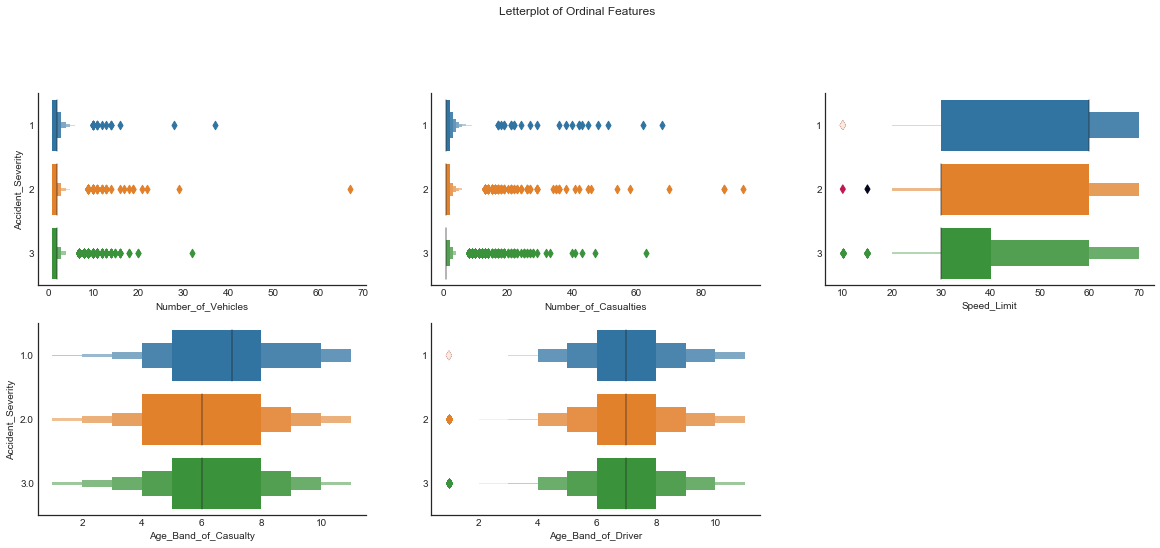

In [14]:
fig = plt.figure(figsize=[20, 12])
nrow, ncol, ind = 3, 3, 1
ind = plot_lv_relation_with(data = acc[acc.columns[acc.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = cas.merge(acc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = veh.merge(acc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
fig.suptitle("Letterplot of Ordinal Features")
plt.show()
del tmp

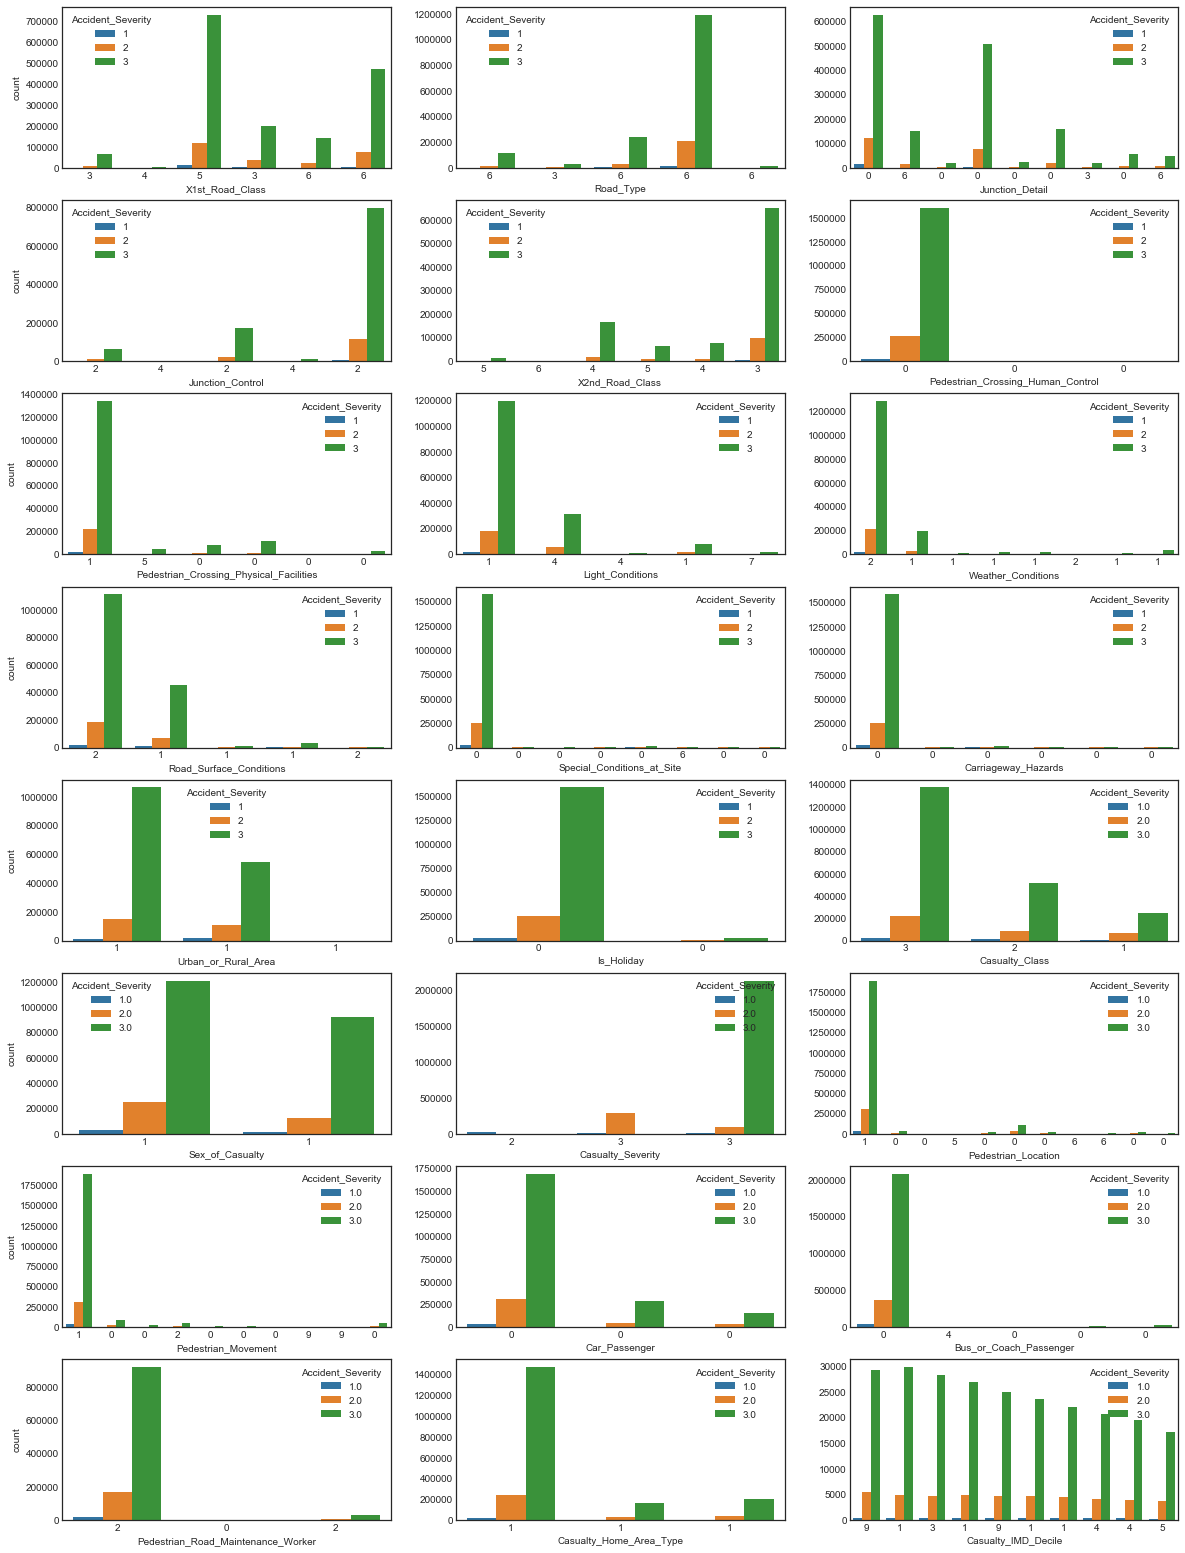

In [15]:
fig = plt.figure(figsize=[20, 170])
nrow = len(acccat) + len(vehcat) + len(cascat)
ind = count_all(acc, acccat, hue="Accident_Severity", fig=fig, nrow=nrow)
ind = count_all(cas.merge(acc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)
ind = count_all(veh.merge(acc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)

In [16]:
###############END######################

## Missing data

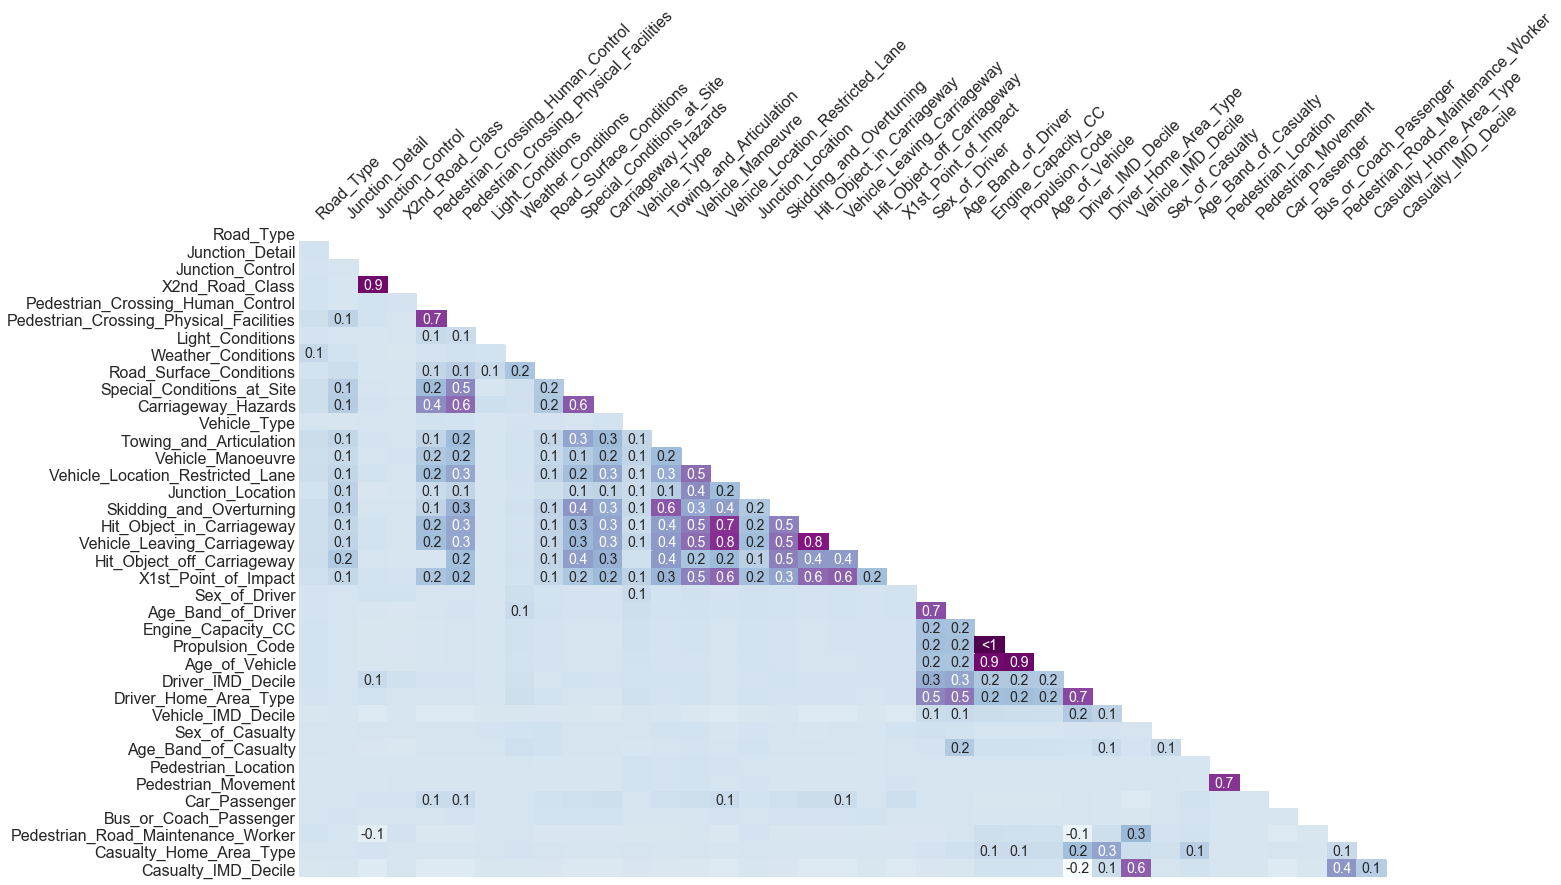

In [17]:
msno.heatmap(auto_drop(acc.merge(veh, on='Accident_Index', how='inner').merge(cas, on='Accident_Index', how='inner')), cmap='BuPu')

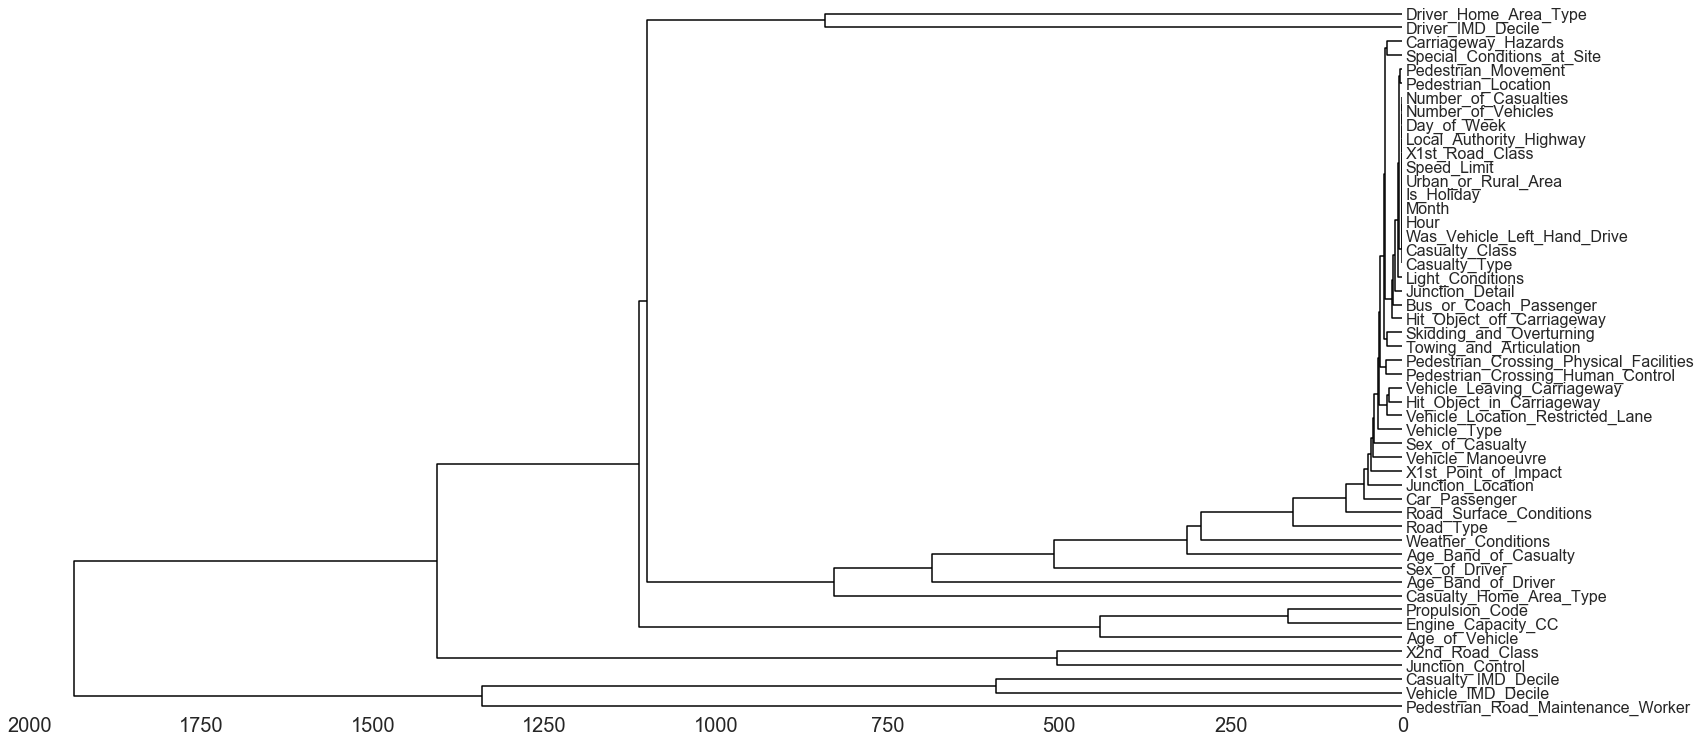

In [128]:
msno.dendrogram(auto_drop(acc.merge(veh, on = 'Accident_Index', how = 'inner').merge(cas, on='Accident_Index', how='inner')))

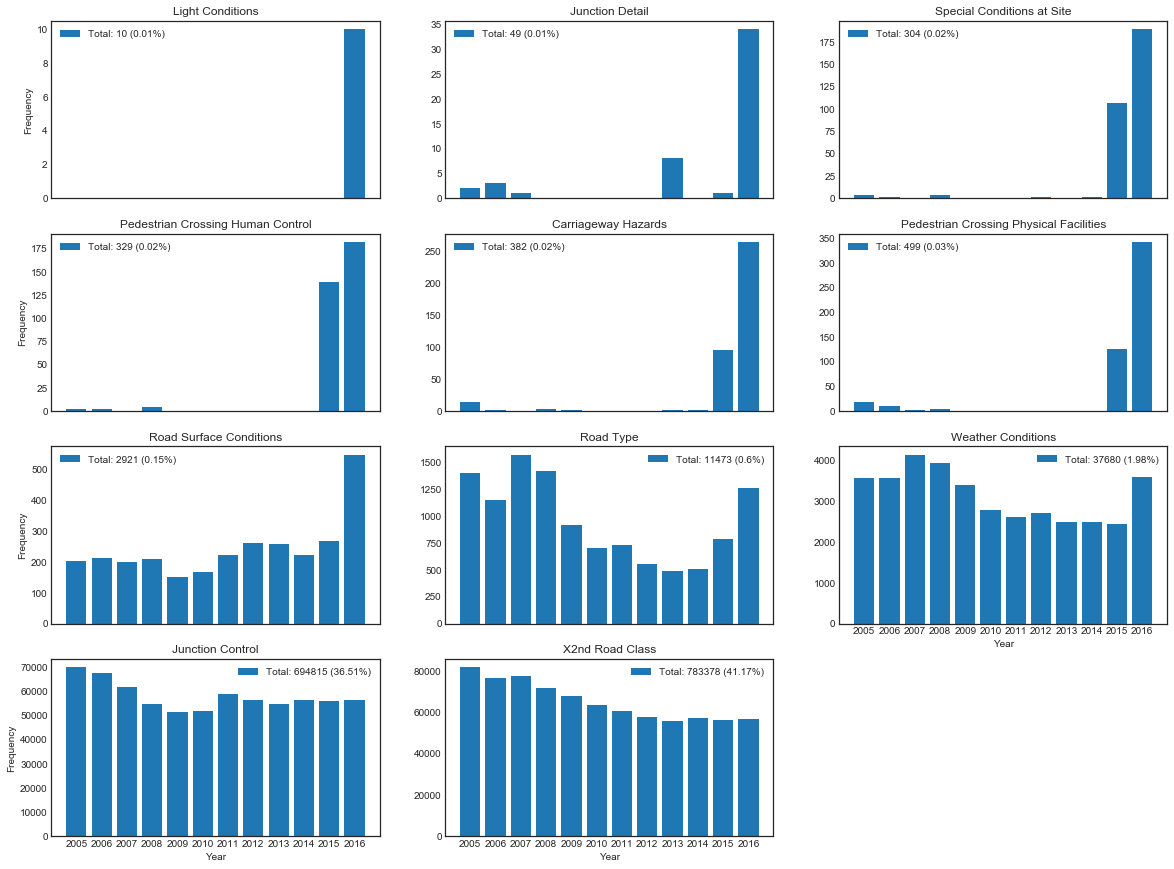

In [25]:
# How many are missing each year? Maybe survey is different by year
plot_yearly_missing_data_cols(data = auto_drop(acc), fig = plt.figure(figsize=[20,15]))
plt.show()

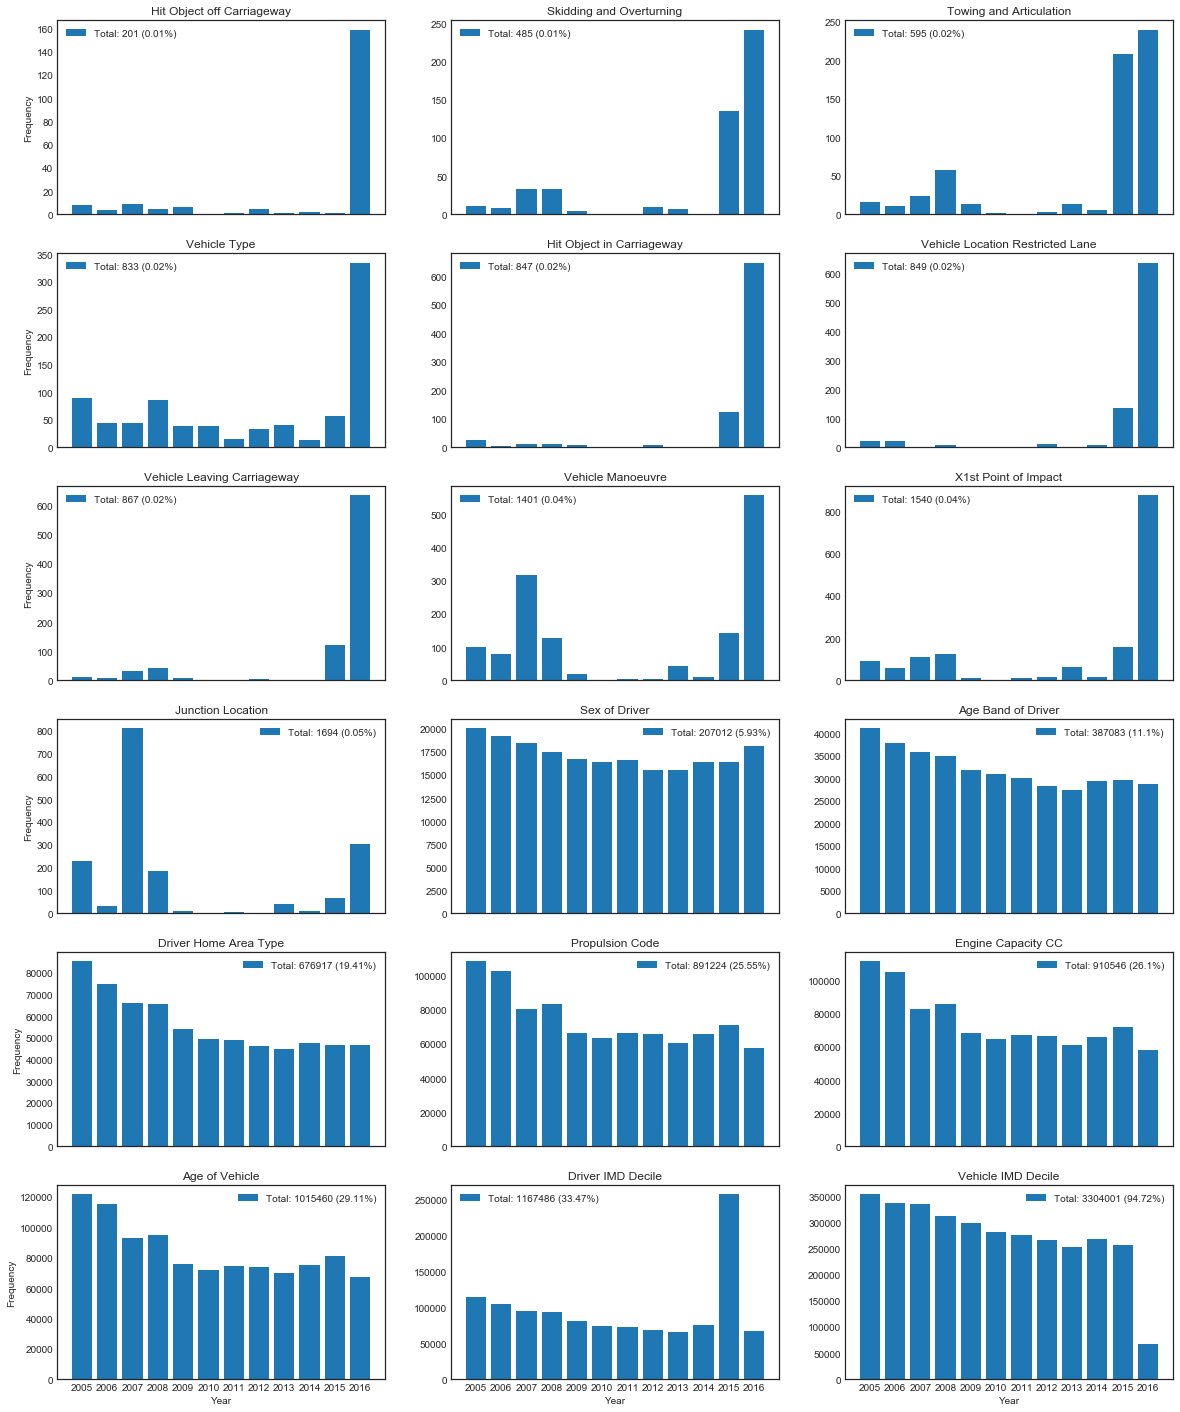

In [26]:
plot_yearly_missing_data_cols(data = auto_drop(veh.merge(acc.loc[:, ('Accident_Index', 'Year')], how = 'left')), 
                              fig = plt.figure(figsize=[20, 25]))
plt.show()

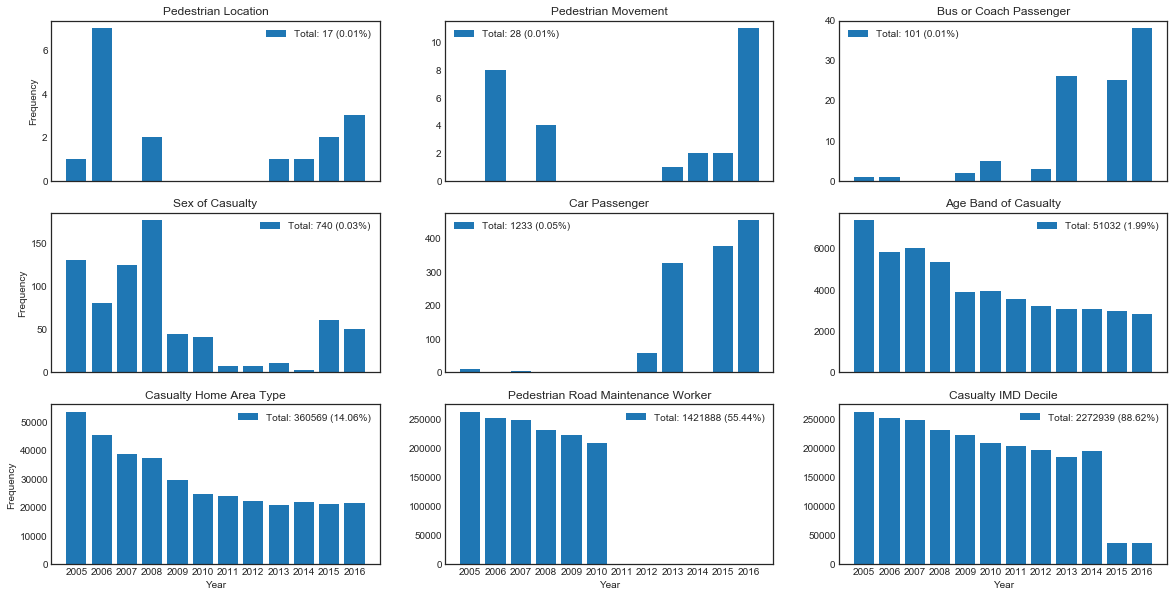

In [27]:
plot_yearly_missing_data_cols(data = auto_drop(cas.merge(acc.loc[:, ('Accident_Index', 'Year')], on = 'Accident_Index', how = 'inner')), 
                              fig = plt.figure(figsize=[20, 10]))
plt.show()

In [28]:
###############END######################

# Analysis 2

In [29]:
# import data
iacc = pd.read_csv(dirs["imp"] + "acc2005_2015-v2018.2.5.imp.csv").merge(acc[["Accident_Index", "Number_of_Casualties", "Local_Authority_Highway"]], how="left")
iveh = pd.read_csv(dirs["imp"] + "veh2005_2015-v2018.2.5.imp.csv")
icas = pd.read_csv(dirs["imp"] + "cas2005_2015-v2018.2.5.imp.csv")

## General

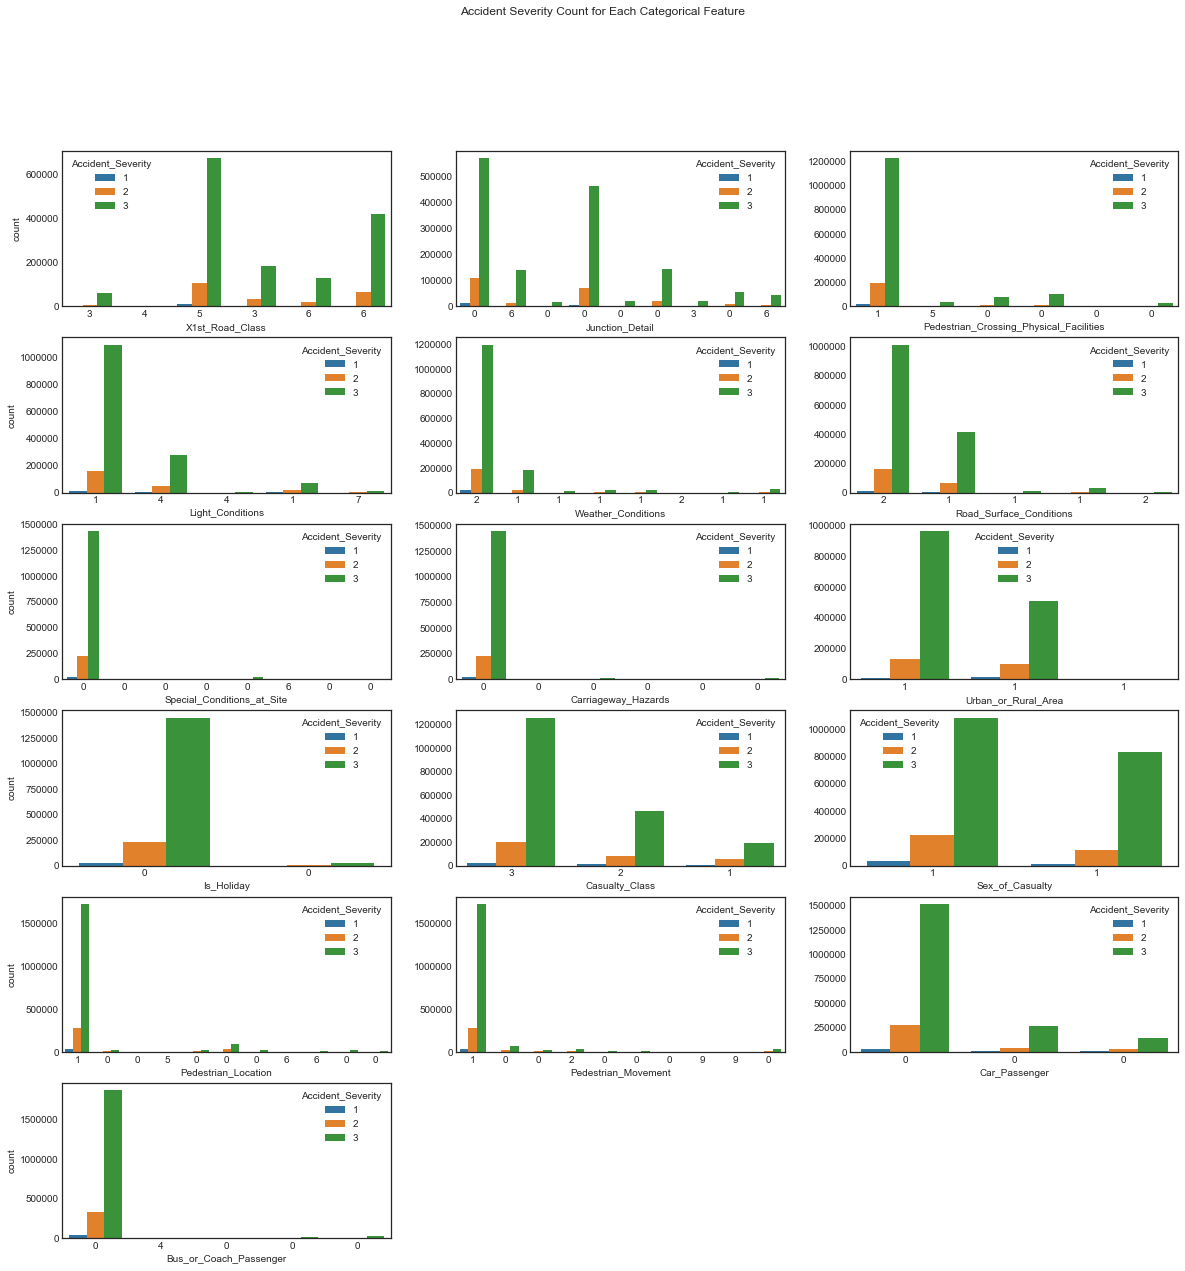

In [30]:
fig = plt.figure(figsize=[20, 20])
fig.suptitle("Accident Severity Count for Each Categorical Feature")
nrow = 6
ind = count_all(iacc, acccat, hue="Accident_Severity", fig=fig, nrow=nrow)
ind = count_all(icas.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)
ind = count_all(iveh.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left"), cascat, hue="Accident_Severity", fig=fig, nrow=nrow, ind=ind)

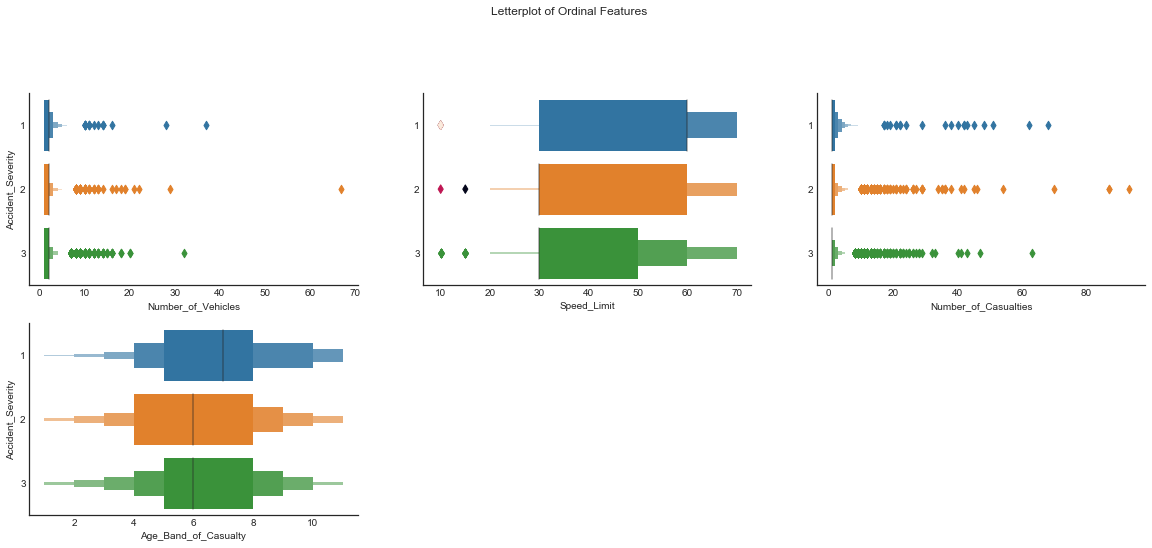

In [31]:
fig = plt.figure(figsize=[20, 12])
nrow, ncol, ind = 3, 3, 1
ind = plot_lv_relation_with(data = iacc[iacc.columns[iacc.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = icas.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
tmp = iveh.merge(iacc[["Accident_Index", "Accident_Severity"]], how="left")
ind = plot_lv_relation_with(data = tmp[tmp.columns[tmp.columns.isin(ordinal)]], 
                            fig = fig, dv = 'Accident_Severity', orient = 'h', ncol = ncol, nrow = nrow, ind = ind)
fig.suptitle("Letterplot of Ordinal Features")
plt.show()
del tmp

In [32]:
# del icas, iveh, iacc, acc, cas, veh
##############END########################

## Feature Selection 2

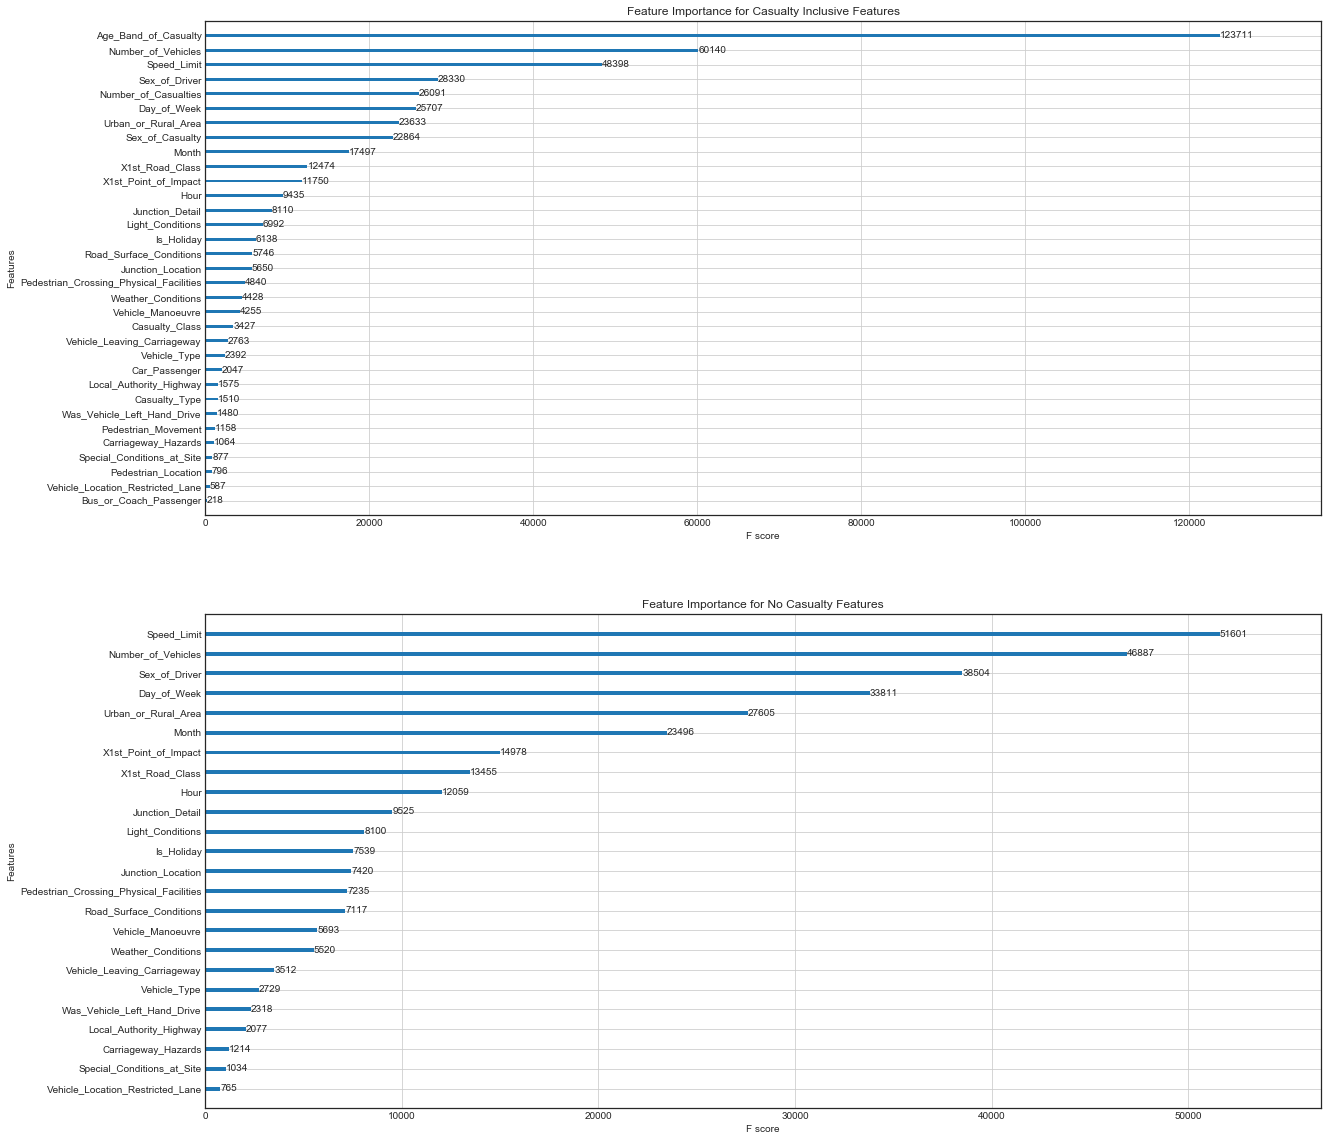

In [33]:
tmp = joblib.load("plots/xgb_feature_importance.cas.pkl.xz")
f = dict()
for k, v in tmp.items():
    f[k] = int(np.round(v))
fig = plt.figure(figsize=[20, 20])

ax = fig.add_subplot(211)
xgb.plot_importance(f, ax=ax, title="Feature Importance for Casualty Inclusive Features")

tmp = joblib.load("plots/xgb_feature_importance.nocas.pkl.xz")
f = dict()
for k, v in tmp["xgtf"].items():
    f[k] = int(np.round(v))

ax = fig.add_subplot(212)
xgb.plot_importance(f, ax=ax, title="Feature Importance for No Casualty Features")

plt.show()

del f, tmp

## Modelling

In [34]:
# import model use data
tap = joblib.load("tap2005_2015-v2018.2.5.imp.model.pkl.z")
all_train_columns = np.invert(tap.columns.isin([
    'Accident_Index', 'Accident_Severity', 'Date_Time', 'Year'
]))
freq_columns = ['Number_of_Vehicles', 'Speed_Limit', 'Age_Band_of_Casualty', 'Number_of_Casualties']
cat_columns = tap.columns[all_train_columns].drop(freq_columns)
cas_columns = ['Casualty_Class', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Casualty_Type', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Number_of_Casualties']

## Analysis

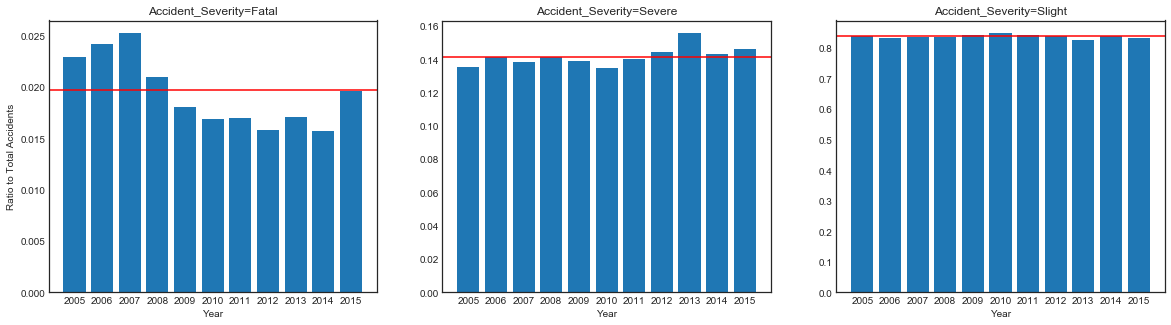

In [35]:
baseline_ratio = np.divide(tap["Accident_Severity"].value_counts(), tap["Accident_Severity"].value_counts().sum())
every_year_num_of_acc = tap.groupby("Year").count()["Accident_Index"]
ratio_store = OrderedDict([
    (sev, []) for sev in sorted(pd.unique(tap["Accident_Severity"]))
])
for sev, _ in ratio_store.items():
    severity_count = tap[tap["Accident_Severity"] == sev].groupby("Year").count()["Accident_Index"]
    ratio_store[sev] = np.divide(severity_count, every_year_num_of_acc)

fig = plt.figure(figsize=[20,5])
ind = 131

for sev, ratio in ratio_store.items():
    ax = fig.add_subplot(ind)
    ax.bar(sorted(pd.unique(tap["Year"])), ratio)
    ax.axhline(baseline_ratio[sev], color="red")
    ax.set_title("Accident_Severity=" + accident_severity_mapping[sev])
    ax.set_xticks(sorted(pd.unique(tap["Year"])))
    ax.set_xlabel("Year")
    if ind == 131:
        ax.set_ylabel("Ratio to Total Accidents")
    ind += 1

In [59]:
sampled = joblib.load("test/stratified_traintest.pkl.xz")
ignore_cols = ['Accident_Index', 'Date_Time', 'Year']
sel_cols = ['Accident_Severity', 'Age_Band_of_Casualty', 'Number_of_Vehicles', 'Speed_Limit', 'Sex_of_Driver', 'Number_of_Casualties', 
            'Day_of_Week', 'Urban_or_Rural_Area']
# Only interested in training data
df_sampled = pd.DataFrame(sampled["X"].copy())
df_sampled["Accident_Severity"] = sampled["Y"].copy()
_, x_sample, _, y_sample = train_test_split(df_sampled.drop("Accident_Severity", axis=1), df_sampled["Accident_Severity"], 
                                           test_size=0.2, stratify=df_sampled["Accident_Severity"])
geo_df_sampled = df_sampled.drop_duplicates(subset=["Accident_Index"]).merge(acc[["Accident_Index", "Longitude", "Latitude"]], how="left", on="Accident_Index")
del sampled

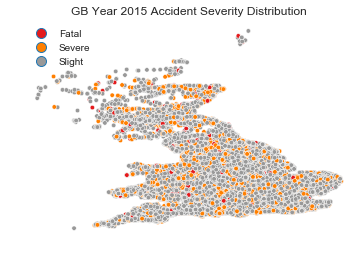

In [120]:
geodata = to_geodf(geo_df_sampled)
fig, ax = plt.subplots()
ax.set_title("GB Year 2015 Accident Severity Distribution")
ax = gplt.pointplot(geodata, hue='Accident_Severity', categorical=True, legend_labels=["Fatal", "Severe", "Slight"],
               legend=True, edgecolor='white', linewidth=0.5, legend_kwargs={'loc': 'upper left'}, ax=ax)

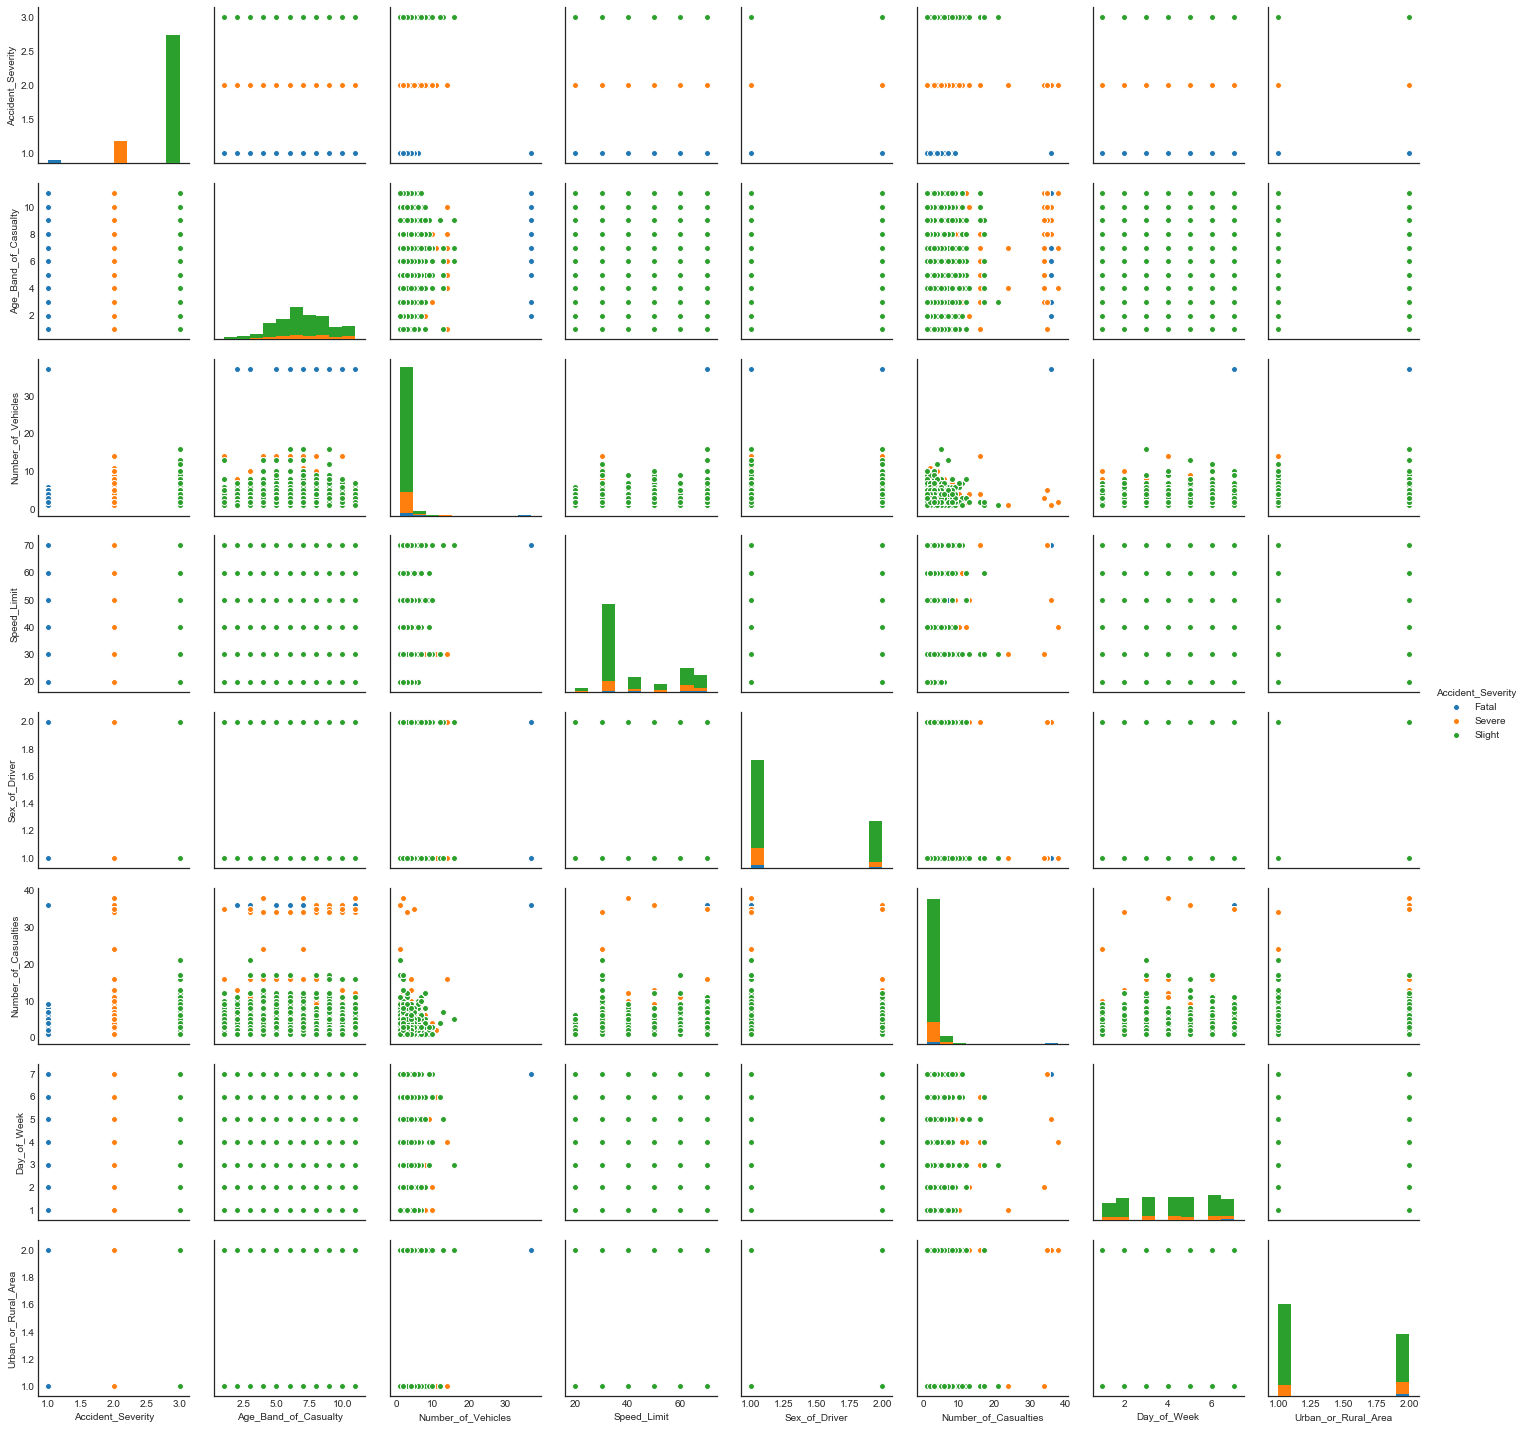

In [38]:
g = sns.pairplot(x_sample.join(y_sample)[sel_cols], hue="Accident_Severity")
new_labels = ['Fatal', 'Severe', 'Slight']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [39]:
cas_sample = pd.read_csv("train/stratified_XY_train.oh.tlsmote.cas.v2.csv")
nocas_sample = pd.read_csv("train/stratified_XY_train.oh.tlsmote.nocas.v2.csv")

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\ipykernel_launcher.py:183: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.


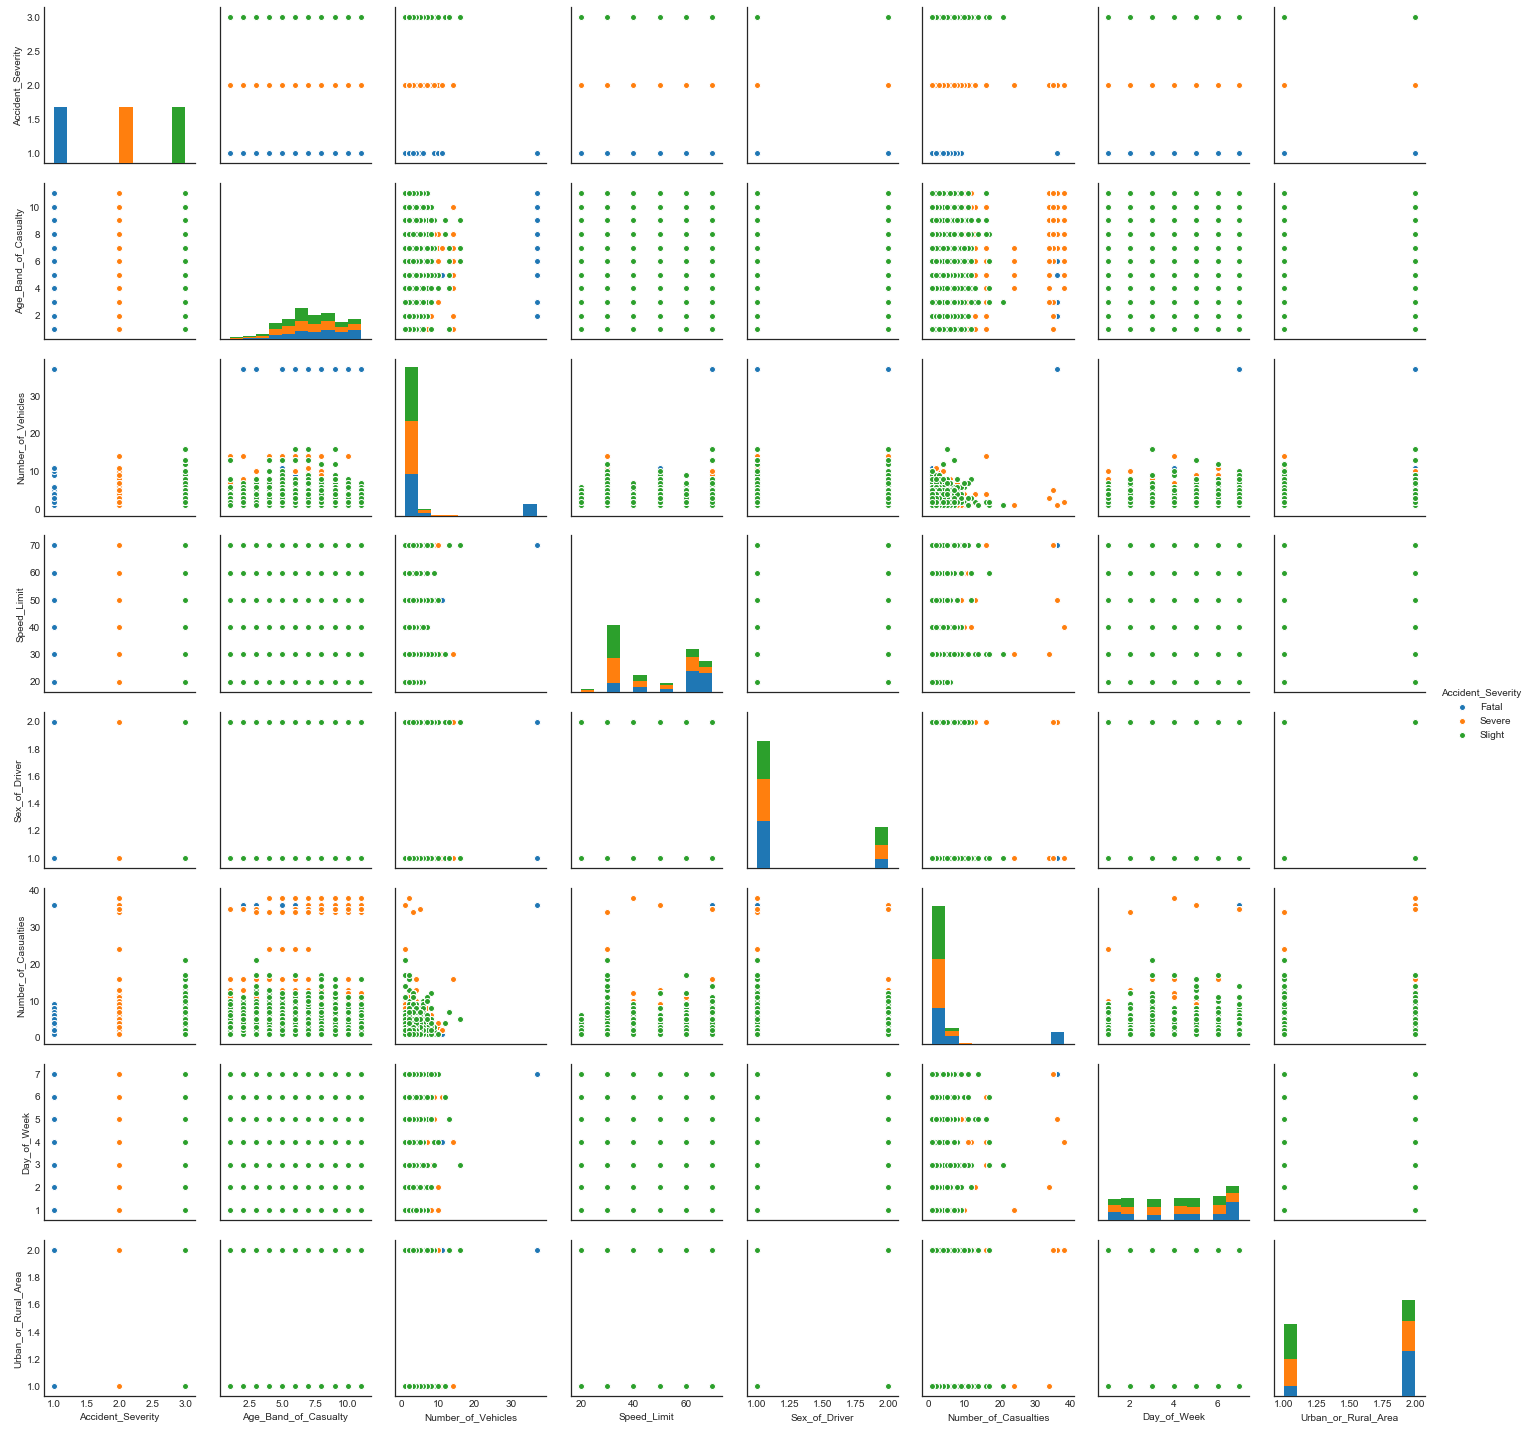

In [40]:
rev_cas_sample = reverse_dummy(cas_sample)
rev_cas_sample["Accident_Severity"] = cas_sample["Accident_Severity"].copy()
_, x_sample, _, y_sample = train_test_split(rev_cas_sample[rev_cas_sample.columns[rev_cas_sample.columns.isin(sel_cols)]].drop("Accident_Severity", axis=1), rev_cas_sample["Accident_Severity"], 
                                           test_size=0.2, stratify=rev_cas_sample["Accident_Severity"])
g = sns.pairplot(x_sample.join(y_sample)[sel_cols], hue="Accident_Severity")
new_labels = ['Fatal', 'Severe', 'Slight']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

# Result

In [41]:
test_data = joblib.load("test/stratified_traintest.pkl.xz")

## Random Forest

## OOB

In [42]:
nocas_oob = joblib.load("rf_oob/rf_oob-score.nocas.v2.pkl.xz")
nocas_oob_met = joblib.load("rf_oob/rf_oob-score-metrics.nocas.v2.pkl.xz")
cas_oob = joblib.load("rf_oob/rf_oob-score.cas.v2.pkl.xz")
cas_oob_met = joblib.load("rf_oob/rf_oob-score-metrics.cas.v2.pkl.xz")

In [43]:
nocas_oob_met_plotter = dict()
for k, v in nocas_oob_met.items():
    nocas_oob_met_plotter[k] = {
        "ntrees": [],
        "accuracy": [],
        "f1_macro": [],
        "specificity": []
    }
    for i in v:
        nocas_oob_met_plotter[k]["ntrees"].append(i[0])
        nocas_oob_met_plotter[k]["accuracy"].append(i[1]["accuracy"])
        nocas_oob_met_plotter[k]["f1_macro"].append(i[1]["f1_macro"])
        nocas_oob_met_plotter[k]["specificity"].append(i[1]["specificity"])
    
cas_oob_met_plotter = dict()
for k, v in nocas_oob_met.items():
    cas_oob_met_plotter[k] = {
        "ntrees": [],
        "accuracy": [],
        "f1_macro": [],
        "specificity": []
    }
    for i in v:
        cas_oob_met_plotter[k]["ntrees"].append(i[0])
        cas_oob_met_plotter[k]["accuracy"].append(i[1]["accuracy"])
        cas_oob_met_plotter[k]["f1_macro"].append(i[1]["f1_macro"])
        cas_oob_met_plotter[k]["specificity"].append(i[1]["specificity"])

In [44]:
rf_cas = joblib.load("final/rf.final.cas.v2.pkl.xz")
rf_nocas = joblib.load("final/rf.final.nocas.v2.pkl.xz")

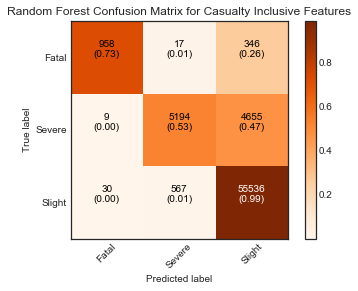

In [45]:
plot_confusion_matrix(cm=rf_cas["result"]["confusion_matrix"], 
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges,
                      title="Random Forest Confusion Matrix for Casualty Inclusive Features")

In [46]:
met.parse_evaluate_model_print(rf_nocas["result"])

name:
nocas-final

accuracy:
0.8994087235559781

confusion_matrix:
[[ 1031    25   265]
 [   38  5714  4106]
 [  140  2197 53796]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.85      0.78      1.00      0.82      0.92      0.84      1321
          2       0.72      0.58      0.96      0.64      0.82      0.66      9858
          3       0.92      0.96      0.61      0.94      0.83      0.70     56133

avg / total       0.89      0.90      0.67      0.90      0.83      0.70     67312


sensitivity:
0.7728222780994428

specificity:
0.8558757535671128

f1_micro:
0.8994087235559781

f1_weighted:
0.8950338438715346

f1_macro:
0.7995236852518789



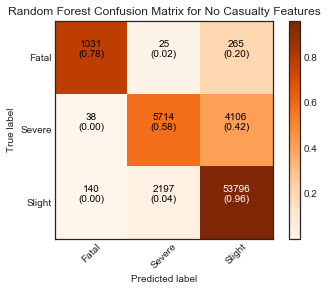

In [47]:
plot_confusion_matrix(cm=rf_nocas["result"]["confusion_matrix"], 
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges, 
                     title="Random Forest Confusion Matrix for No Casualty Features")

In [48]:
met.parse_evaluate_model_print(rf_cas["result"])

name:
nocas-final

accuracy:
0.9164487758497741

confusion_matrix:
[[  958    17   346]
 [    9  5194  4655]
 [   30   567 55536]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.96      0.73      1.00      0.83      0.98      0.95      1321
          2       0.90      0.53      0.99      0.66      0.91      0.83      9858
          3       0.92      0.99      0.55      0.95      0.91      0.84     56133

avg / total       0.92      0.92      0.63      0.91      0.92      0.84     67312


sensitivity:
0.7471514803249116

specificity:
0.8472959019981544

f1_micro:
0.9164487758497741

f1_weighted:
0.9074290389512684

f1_macro:
0.8143191448676311



## ANN

In [49]:
nn_cas = joblib.load("final/nn.val.final.cas.v2.pkl.xz")
nn_nocas = joblib.load("final/nn.val.final.nocas.v2.pkl.xz")
epochs = np.arange(1, 201, 1)

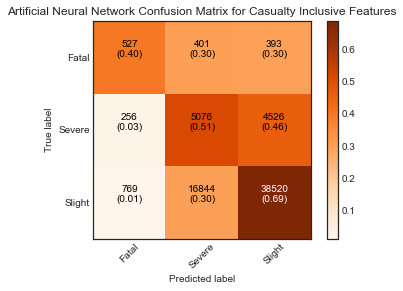

In [50]:
plot_confusion_matrix(cm=nn_cas["result"]["confusion_matrix"], 
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges, 
                      title="Artificial Neural Network Confusion Matrix for Casualty Inclusive Features")

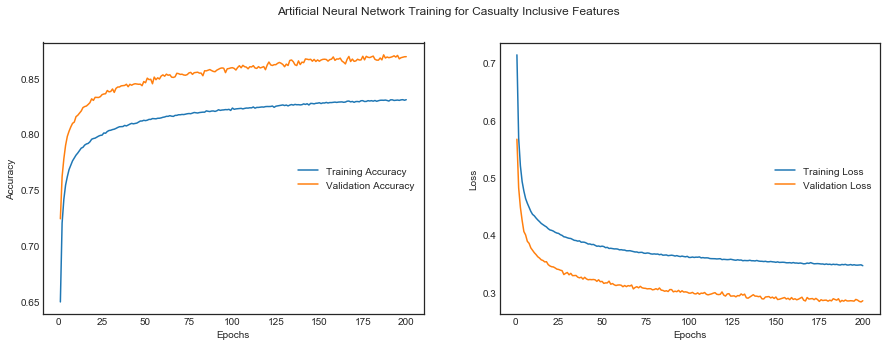

In [51]:
fig = plt.figure(figsize=[15, 5])
ind = 121

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_cas["history"]["categorical_accuracy"])
l1 = ax.plot(x, y, label="Training Accuracy")
x, y = simple_line_numeric(epochs, nn_cas["history"]["val_categorical_accuracy"])
l2 = ax.plot(x, y, label="Validation Accuracy")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_cas["history"]["loss"])
l1 = ax.plot(x, y, label="Training Loss")
x, y = simple_line_numeric(epochs, nn_cas["history"]["val_loss"])
l2 = ax.plot(x, y, label="Validation Loss")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ind += 1

fig.suptitle("Artificial Neural Network Training for Casualty Inclusive Features")
plt.show()

In [52]:
met.parse_evaluate_model_print(nn_cas["result"])

name:
.cas.v2

accuracy:
0.655499762300927

confusion_matrix:
[[  527   401   393]
 [  256  5076  4526]
 [  769 16844 38520]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.34      0.40      0.98      0.37      0.58      0.31      1321
          2       0.23      0.51      0.70      0.32      0.45      0.19      9858
          3       0.89      0.69      0.56      0.77      0.48      0.25     56133

avg / total       0.78      0.66      0.59      0.70      0.48      0.24     67312


sensitivity:
0.533359765506412

specificity:
0.7480976480252433

f1_micro:
0.655499762300927

f1_weighted:
0.6986187849519915

f1_macro:
0.4853535482801153



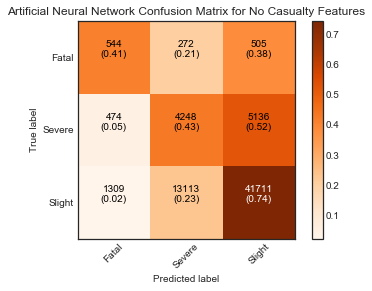

In [53]:
plot_confusion_matrix(cm=nn_nocas["result"]["confusion_matrix"], 
                      classes=["Fatal", "Severe", "Slight"], cmap=plt.cm.Oranges,
                      title="Artificial Neural Network Confusion Matrix for No Casualty Features")

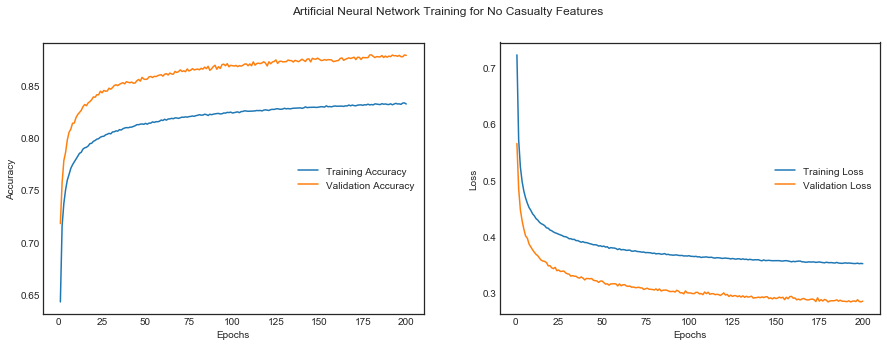

In [54]:
fig = plt.figure(figsize=[15, 5])
ind = 121

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_nocas["history"]["categorical_accuracy"])
l1 = ax.plot(x, y, label="Training Accuracy")
x, y = simple_line_numeric(epochs, nn_nocas["history"]["val_categorical_accuracy"])
l2 = ax.plot(x, y, label="Validation Accuracy")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ind += 1

ax = fig.add_subplot(ind)
x, y = simple_line_numeric(epochs, nn_nocas["history"]["loss"])
l1 = ax.plot(x, y, label="Training Loss")
x, y = simple_line_numeric(epochs, nn_nocas["history"]["val_loss"])
l2 = ax.plot(x, y, label="Validation Loss")
ax.legend(loc="center right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ind += 1

fig.suptitle("Artificial Neural Network Training for No Casualty Features")
plt.show()

In [55]:
met.parse_evaluate_model_print(nn_nocas["result"])

name:
.nocas.v2

accuracy:
0.6908574994057524

confusion_matrix:
[[  544   272   505]
 [  474  4248  5136]
 [ 1309 13113 41711]]

report:
                   pre       rec       spe        f1       geo       iba       sup

          1       0.23      0.41      0.97      0.30      0.48      0.21      1321
          2       0.24      0.43      0.77      0.31      0.46      0.20      9858
          3       0.88      0.74      0.50      0.81      0.49      0.26     56133

avg / total       0.77      0.69      0.54      0.72      0.49      0.25     67312


sensitivity:
0.5286009232534258

specificity:
0.7451351093606373

f1_micro:
0.6908574994057524

f1_weighted:
0.7233608000374293

f1_macro:
0.47113956762177



## Random search

In [56]:
rs_casres = pd.read_csv("search/rf/randomsearch_rf.cas.v2.csv").sort_values("rank_test_f1_macro")
rs_nocasres = pd.read_csv("search/rf/randomsearch_rf.nocas.v2.csv").sort_values("rank_test_f1_macro")
# Use "rank_test_f1_macro" as xticks
plot_lines = [
    ('mean_test_f1_macro', "std_test_f1_macro"), 
    ('mean_test_precision_macro', "std_test_precision_macro"), 
    ('mean_test_recall_macro', "std_test_recall_macro")
] 

C:\Anaconda\envs\fyp_tap_env\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


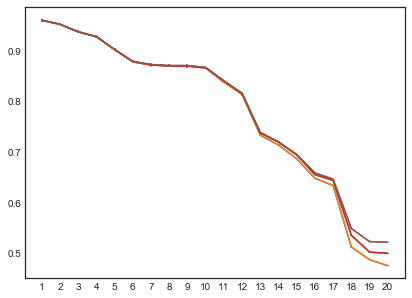

In [57]:
fig = plt.figure(figsize=[15, 5])
ind = 121

for pl in plot_lines:
    ax = fig.add_subplot(ind)
    x, y = simple_line_numeric(rs_nocasres["rank_test_f1_macro"], rs_nocasres[pl[0]])
    ax.plot(x, y)
    ax.errorbar(x, y, yerr=rs_nocasres[pl[1]])
    ax.set_xticks(rs_nocasres["rank_test_f1_macro"])